In [1]:
import numpy as np                              
import pandas as pd

import matplotlib.pyplot as plt     

import seaborn as sns                          

import featuretools as ft

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from featuretools.primitives import (Minute, Hour, Day, Month,
                                     Weekday, IsWeekend, Count, Sum, Mean, Median, Std, Min, Max)
from sklearn.metrics import roc_curve,classification_report
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    precision_recall_curve
)

print(ft.__version__)
%load_ext autoreload
%autoreload 2

0.27.0


In [2]:
travel = pd.read_csv('Traveldata_train.csv')
survey = pd.read_csv('Surveydata_train.csv')


In [3]:
survey.head()

,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0,Needs Improvement,Green Car,Excellent,Excellent,Very Convenient,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor
1,98800002,0,Poor,Ordinary,Excellent,Poor,Needs Improvement,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good
2,98800003,1,Needs Improvement,Green Car,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent
3,98800004,0,Acceptable,Ordinary,Needs Improvement,NaN,Needs Improvement,Acceptable,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Good,Acceptable,Acceptable
4,98800005,1,Acceptable,Ordinary,Acceptable,Acceptable,Manageable,Needs Improvement,Good,Excellent,Good,Good,Good,Good,Good,Good,Good


In [4]:
travel.head()

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,98800001,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0
1,98800002,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,98800003,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0
3,98800004,Female,Loyal Customer,44.0,Business Travel,Business,780,13.0,18.0
4,98800005,Female,Loyal Customer,50.0,Business Travel,Business,1981,0.0,0.0


In [5]:
travel.shape

(94379, 9)

In [6]:
survey.shape

(94379, 17)

In [7]:
travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.5+ MB


In [8]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       94379 non-null  int64 
 1   Overall_Experience       94379 non-null  int64 
 2   Seat_Comfort             94318 non-null  object
 3   Seat_Class               94379 non-null  object
 4   Arrival_Time_Convenient  85449 non-null  object
 5   Catering                 85638 non-null  object
 6   Platform_Location        94349 non-null  object
 7   Onboard_Wifi_Service     94349 non-null  object
 8   Onboard_Entertainment    94361 non-null  object
 9   Online_Support           94288 non-null  object
 10  Ease_of_Online_Booking   94306 non-null  object
 11  Onboard_Service          86778 non-null  object
 12  Legroom                  94289 non-null  object
 13  Baggage_Handling         94237 non-null  object
 14  CheckIn_Service          94302 non-nul

In [9]:
survey.isnull().sum()

ID                            0
Overall_Experience            0
Seat_Comfort                 61
Seat_Class                    0
Arrival_Time_Convenient    8930
Catering                   8741
Platform_Location            30
Onboard_Wifi_Service         30
Onboard_Entertainment        18
Online_Support               91
Ease_of_Online_Booking       73
Onboard_Service            7601
Legroom                      90
Baggage_Handling            142
CheckIn_Service              77
Cleanliness                   6
Online_Boarding               6
dtype: int64

In [10]:
travel.isnull().sum()

ID                            0
Gender                       77
Customer_Type              8951
Age                          33
Type_Travel                9226
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      57
Arrival_Delay_in_Mins       357
dtype: int64

# Preprocessing and data cleaning


Lets process the data.
First encoding categorical values


## Encoding Categorical Ratings

For Survey categorical values, those ones are hierarchical, it can therefore be encoded from 1 to 5. 

In [11]:
for column in survey.select_dtypes(include=['object']):
    survey[column].mask(survey[column] == 'Extremely Poor', 0, inplace=True)
    survey[column].mask(survey[column] == 'Poor', 1, inplace=True)
    survey[column].mask(survey[column] == 'Needs Improvement', 2, inplace=True)
    survey[column].mask(survey[column] == 'Acceptable', 3, inplace=True)
    survey[column].mask(survey[column] == 'Good', 4, inplace=True)
    survey[column].mask(survey[column] == 'Excellent', 5, inplace=True)
    survey[column].mask(survey[column] == 'Very Inconvenient', 0, inplace=True)
    survey[column].mask(survey[column] == 'Inconvenient', 1, inplace=True)
    survey[column].mask(survey[column] == 'Manageable', 3, inplace=True)
    survey[column].mask(survey[column] == 'Convenient', 4, inplace=True)
    survey[column].mask(survey[column] == 'Very Convenient', 5, inplace=True)

for column in survey.select_dtypes(include=['object']):
    print(survey[column].unique())

[2 1 3 4 5 0 nan]
['Green Car' 'Ordinary']
[5 2 3 nan 4 1 0]
[5 1 2 nan 3 4 0]
[5 2 3 1 4 nan 0]
[4 2 3 5 1 0 nan]
[2 1 4 5 3 0 nan]
[3 4 5 1 nan 2 0]
[2 4 5 3 1 nan 0]
[2 5 3 4 1 nan 0]
[3 2 5 4 1 0 nan]
[2 1 5 3 4 nan]
[4 2 3 5 1 nan 0]
[2 4 5 3 1 0 nan]
[1 4 5 3 2 nan 0]


In [12]:
travel['Customer_Type'].mask(travel['Customer_Type'] == 'Loyal Customer', 1, inplace=True)
travel['Customer_Type'].mask(travel['Customer_Type'] == 'Disloyal Customer', 0, inplace=True)
travel['Travel_Class'].mask(travel['Travel_Class'] == 'Business', 1, inplace=True)
travel['Travel_Class'].mask(travel['Travel_Class'] == 'Eco', 0, inplace=True)
for column in travel.select_dtypes(include=['object']):
    print(travel[column].unique())

['Female' 'Male' nan]
[1 0 nan]
[nan 'Personal Travel' 'Business Travel']
[1 0]


In [13]:
for column in survey.select_dtypes(include=['object']):
        survey[column].mask(survey[column] == 'Green Car', 1, inplace=True)
        survey[column].mask(survey[column] == 'Ordinary', 0, inplace=True)

for column in survey.select_dtypes(include=['object']):
    print(survey[column].unique())


[2 1 3 4 5 0 nan]
[1 0]
[5 2 3 nan 4 1 0]
[5 1 2 nan 3 4 0]
[5 2 3 1 4 nan 0]
[4 2 3 5 1 0 nan]
[2 1 4 5 3 0 nan]
[3 4 5 1 nan 2 0]
[2 4 5 3 1 nan 0]
[2 5 3 4 1 nan 0]
[3 2 5 4 1 0 nan]
[2 1 5 3 4 nan]
[4 2 3 5 1 nan 0]
[2 4 5 3 1 0 nan]
[1 4 5 3 2 nan 0]


## Dealing with missing values

Due to the large number of NaNs over data and the large number of features, the strategy will be to fill the missing values instead of dropping it. Further adjustments can be done. Through ML filling, or dropping NaNs for certain columns or even dropping a whole column (customer_type or type_travel for example)

<AxesSubplot:>

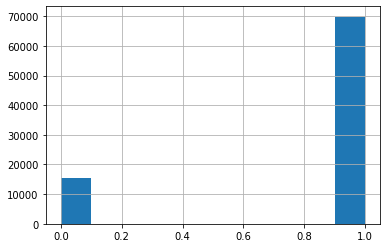

In [14]:
travel['Customer_Type'].hist()

<AxesSubplot:>

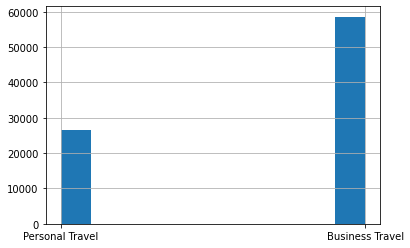

In [15]:
travel['Type_Travel'].hist()

modes are Business travel and Loyal Customer, we will then use "most_frequent" as a strategy to fill NaNs

In [16]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(travel[['Gender']])
travel['Gender'] = imputer.transform(travel[['Gender']])
imputer.fit(travel[['Type_Travel']])
travel['Type_Travel'] = imputer.transform(travel[['Type_Travel']])
imputer.fit(travel[['Customer_Type']])
travel['Customer_Type'] = imputer.transform(travel[['Customer_Type']])


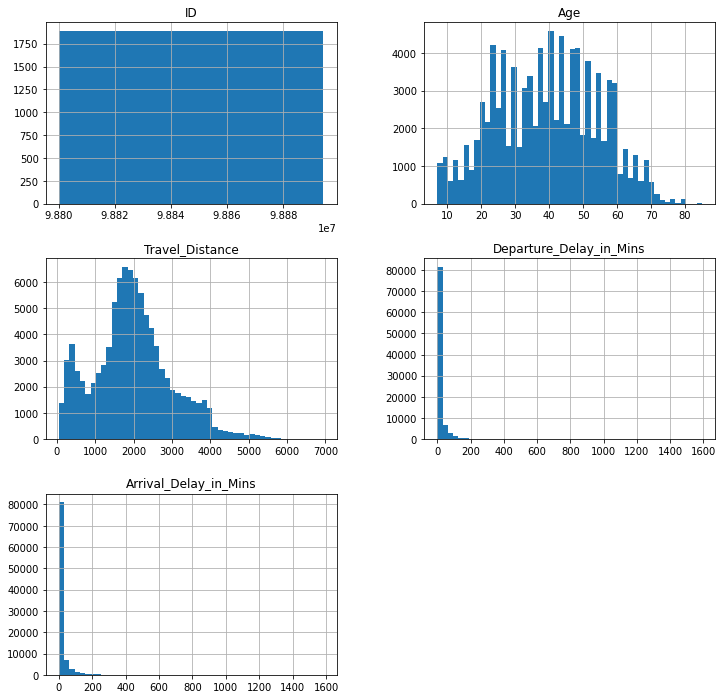

In [17]:
travel.hist(figsize=(12,12),bins=50)
plt.show()

We can observe that Age is somewhat normally distributed while arrival and departure delay are rightly skewed. Imputing Age by its median and delay by mean is the right strategy

In [18]:
imputer2 = SimpleImputer(missing_values=np.nan, strategy='median')
imputer2.fit(travel[['Age']])
travel['Age'] = imputer2.transform(travel[['Age']])
imputer3 = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer3.fit(travel[['Departure_Delay_in_Mins']])
travel['Departure_Delay_in_Mins'] = imputer3.transform(travel[['Departure_Delay_in_Mins']])
imputer3.fit(travel[['Arrival_Delay_in_Mins']])
travel['Arrival_Delay_in_Mins'] = imputer3.transform(travel[['Arrival_Delay_in_Mins']])

In [20]:
travel.isnull().sum()

ID                         0
Gender                     0
Customer_Type              0
Age                        0
Type_Travel                0
Travel_Class               0
Travel_Distance            0
Departure_Delay_in_Mins    0
Arrival_Delay_in_Mins      0
dtype: int64

No more NaNs in travel

array([[<AxesSubplot:title={'center':'ID'}>,
        <AxesSubplot:title={'center':'Overall_Experience'}>,
        <AxesSubplot:title={'center':'Seat_Comfort'}>,
        <AxesSubplot:title={'center':'Seat_Class'}>],
       [<AxesSubplot:title={'center':'Arrival_Time_Convenient'}>,
        <AxesSubplot:title={'center':'Catering'}>,
        <AxesSubplot:title={'center':'Platform_Location'}>,
        <AxesSubplot:title={'center':'Onboard_Wifi_Service'}>],
       [<AxesSubplot:title={'center':'Onboard_Entertainment'}>,
        <AxesSubplot:title={'center':'Online_Support'}>,
        <AxesSubplot:title={'center':'Ease_of_Online_Booking'}>,
        <AxesSubplot:title={'center':'Onboard_Service'}>],
       [<AxesSubplot:title={'center':'Legroom'}>,
        <AxesSubplot:title={'center':'Baggage_Handling'}>,
        <AxesSubplot:title={'center':'CheckIn_Service'}>,
        <AxesSubplot:title={'center':'Cleanliness'}>],
       [<AxesSubplot:title={'center':'Online_Boarding'}>, <AxesSubplot:>,
   

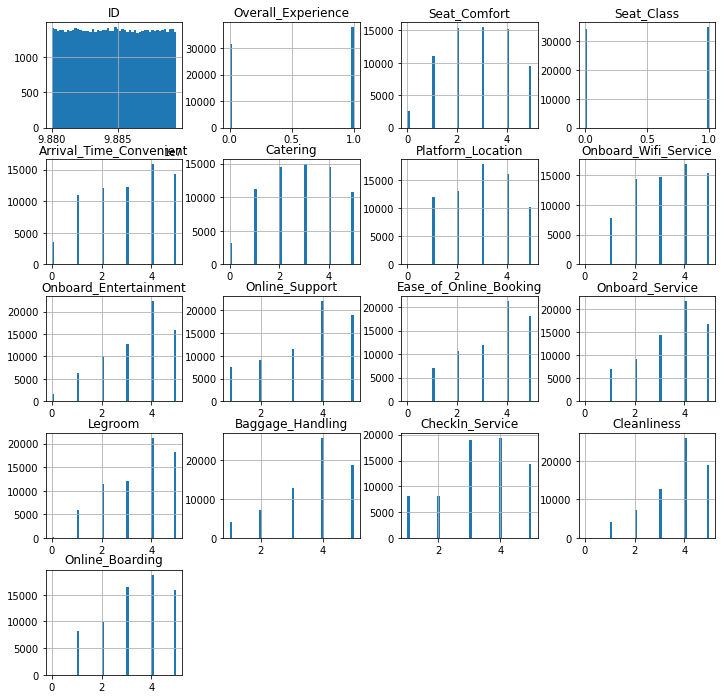

In [19]:
survey.dropna().astype(int).hist(figsize=(12,12),bins=50)

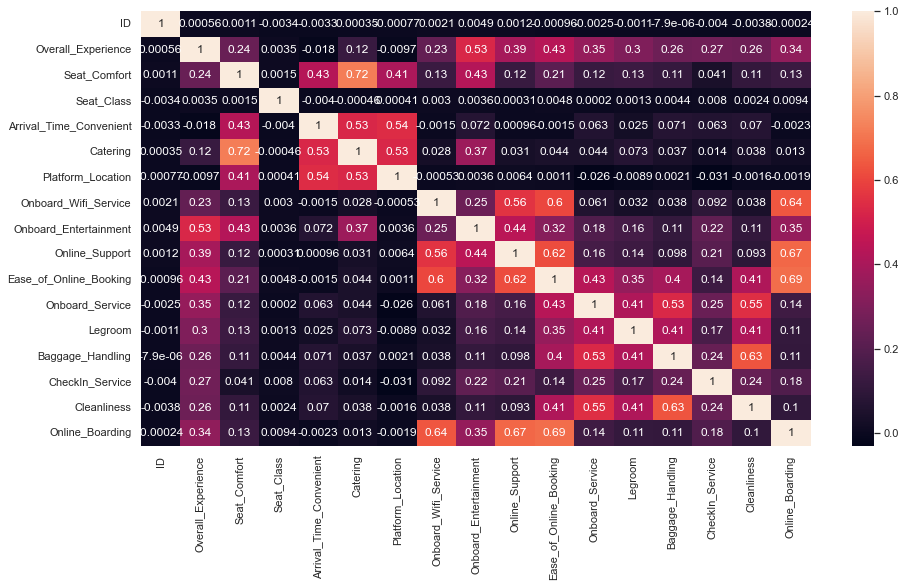

In [20]:
survey_corr=survey.dropna().astype(int)
corrMatrix = survey_corr.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corrMatrix, annot=True)
plt.show()

Distribution and correlation show that the high missing values columns ('Onboard_Service', 'Catering','Arrival_Time_Convenient') are slightly leftly skewed, and no correlation exceeds the 75-80% usual threshold.

The other columns have very few missing values, we will fill it through median since data is categorical and slightly skewed.

In [21]:
for column in survey.drop(['Onboard_Service', 'Catering','Arrival_Time_Convenient'],axis=1):
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    imputer.fit(survey[[column]])
    survey[column] = imputer.transform(survey[[column]])
survey

,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001.0,0.0,2.0,1.0,5,5,5.0,4.0,2.0,3.0,2.0,2,3.0,2.0,4.0,2.0,1.0
1,98800002.0,0.0,1.0,0.0,5,1,2.0,4.0,1.0,4.0,4.0,5,2.0,1.0,2.0,4.0,4.0
2,98800003.0,1.0,2.0,1.0,2,2,2.0,2.0,4.0,5.0,5.0,5,5.0,5.0,4.0,5.0,5.0
3,98800004.0,0.0,3.0,0.0,2,NaN,2.0,3.0,2.0,3.0,3.0,3,3.0,3.0,4.0,3.0,3.0
4,98800005.0,1.0,3.0,0.0,3,3,3.0,2.0,4.0,5.0,4.0,4,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94374,98894375.0,0.0,1.0,0.0,4,4,4.0,1.0,1.0,1.0,1.0,4,4.0,4.0,2.0,4.0,1.0
94375,98894376.0,1.0,4.0,0.0,4,4,4.0,2.0,5.0,5.0,3.0,3,3.0,3.0,4.0,3.0,4.0
94376,98894377.0,1.0,2.0,1.0,2,2,2.0,4.0,5.0,4.0,4.0,4,4.0,4.0,3.0,4.0,3.0
94377,98894378.0,0.0,2.0,0.0,NaN,2,4.0,4.0,2.0,4.0,4.0,3,4.0,4.0,4.0,5.0,4.0


In [22]:
survey.isnull().sum()

ID                            0
Overall_Experience            0
Seat_Comfort                  0
Seat_Class                    0
Arrival_Time_Convenient    8930
Catering                   8741
Platform_Location             0
Onboard_Wifi_Service          0
Onboard_Entertainment         0
Online_Support                0
Ease_of_Online_Booking        0
Onboard_Service            7601
Legroom                       0
Baggage_Handling              0
CheckIn_Service               0
Cleanliness                   0
Online_Boarding               0
dtype: int64

As expected, NaNs only remain in the 3 columns

In [ ]:
## One Hot encoding

In [96]:
survey_train = pd.get_dummies(data = survey, columns=['Seat_Class'], drop_first = True)      

survey_train 

,ID,Overall_Experience,Seat_Comfort,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Seat_Class_1.0
0,98800001.0,0.0,2.0,5,5,5.0,4.0,2.0,3.0,2.0,2,3.0,2.0,4.0,2.0,1.0,1
1,98800002.0,0.0,1.0,5,1,2.0,4.0,1.0,4.0,4.0,5,2.0,1.0,2.0,4.0,4.0,0
2,98800003.0,1.0,2.0,2,2,2.0,2.0,4.0,5.0,5.0,5,5.0,5.0,4.0,5.0,5.0,1
3,98800004.0,0.0,3.0,2,NaN,2.0,3.0,2.0,3.0,3.0,3,3.0,3.0,4.0,3.0,3.0,0
4,98800005.0,1.0,3.0,3,3,3.0,2.0,4.0,5.0,4.0,4,4.0,4.0,4.0,4.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94374,98894375.0,0.0,1.0,4,4,4.0,1.0,1.0,1.0,1.0,4,4.0,4.0,2.0,4.0,1.0,0
94375,98894376.0,1.0,4.0,4,4,4.0,2.0,5.0,5.0,3.0,3,3.0,3.0,4.0,3.0,4.0,0
94376,98894377.0,1.0,2.0,2,2,2.0,4.0,5.0,4.0,4.0,4,4.0,4.0,3.0,4.0,3.0,1
94377,98894378.0,0.0,2.0,NaN,2,4.0,4.0,2.0,4.0,4.0,3,4.0,4.0,4.0,5.0,4.0,0


In [97]:
to_get_dummies_for = ['Gender','Type_Travel','Customer_Type', 'Travel_Class']

# Creating dummy variables
travel_train = pd.get_dummies(data = travel, columns = to_get_dummies_for, drop_first = True)      


travel_train

,ID,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Gender_Male,Type_Travel_Personal Travel,Customer_Type_1,Travel_Class_1
0,98800001,52.0,272,0.0,5.0,0,0,1,1
1,98800002,48.0,2200,9.0,0.0,1,1,1,0
2,98800003,43.0,1061,77.0,119.0,0,0,1,1
3,98800004,44.0,780,13.0,18.0,0,0,1,1
4,98800005,50.0,1981,0.0,0.0,0,0,1,1
...,...,...,...,...,...,...,...,...,...
94374,98894375,32.0,1357,83.0,125.0,1,0,1,1
94375,98894376,44.0,592,5.0,11.0,1,0,1,1
94376,98894377,63.0,2794,0.0,0.0,1,0,1,1
94377,98894378,16.0,2744,0.0,0.0,1,1,1,0


## Merging datasets

In [98]:
train_merged=survey_train.merge(travel_train, on='ID',how='outer')
train_merged.head()

,ID,Overall_Experience,Seat_Comfort,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,...,Online_Boarding,Seat_Class_1.0,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Gender_Male,Type_Travel_Personal Travel,Customer_Type_1,Travel_Class_1
0,98800001.0,0.0,2.0,5,5,5.0,4.0,2.0,3.0,2.0,...,1.0,1,52.0,272,0.0,5.0,0,0,1,1
1,98800002.0,0.0,1.0,5,1,2.0,4.0,1.0,4.0,4.0,...,4.0,0,48.0,2200,9.0,0.0,1,1,1,0
2,98800003.0,1.0,2.0,2,2,2.0,2.0,4.0,5.0,5.0,...,5.0,1,43.0,1061,77.0,119.0,0,0,1,1
3,98800004.0,0.0,3.0,2,NaN,2.0,3.0,2.0,3.0,3.0,...,3.0,0,44.0,780,13.0,18.0,0,0,1,1
4,98800005.0,1.0,3.0,3,3,3.0,2.0,4.0,5.0,4.0,...,4.0,0,50.0,1981,0.0,0.0,0,0,1,1


Lets check correlation Matrix

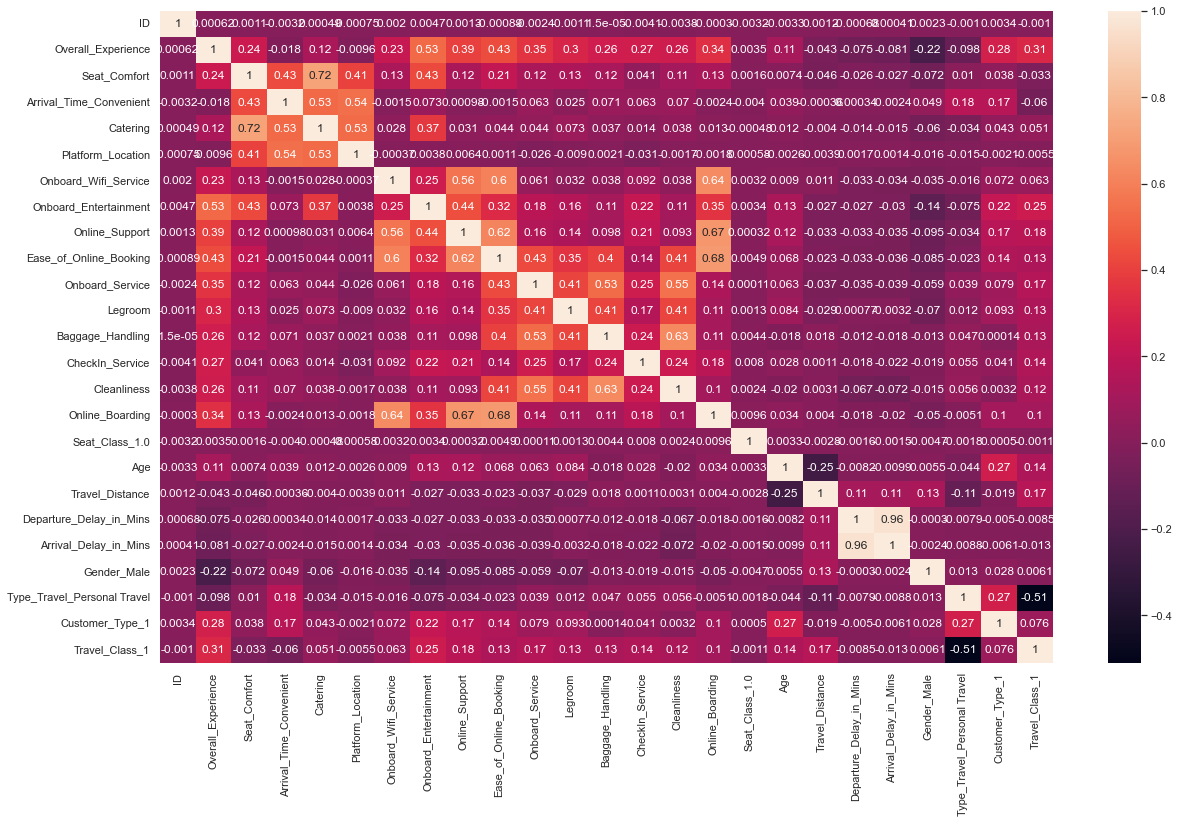

In [99]:
train_mergedcorr=train_merged.dropna().astype(int)
corrMatrix = train_mergedcorr.corr()
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(corrMatrix, annot=True)
plt.show()

Lets drop the columns Catering because correlation to overall experience is limited, and the feature is highly correlated to other variables such as seat_comfort.
We will also drop arrival_time_convenient because of the very low correlation to target. Finally we will drop lines related to nan values in onboard_service since this feature is highly correlated to the target and needs therefore minimum noise.

In [112]:
data=train_merged.drop(axis=1, columns=['Catering','Arrival_Time_Convenient'])
data.isnull().sum()

ID                                0
Overall_Experience                0
Seat_Comfort                      0
Platform_Location                 0
Onboard_Wifi_Service              0
Onboard_Entertainment             0
Online_Support                    0
Ease_of_Online_Booking            0
Onboard_Service                7601
Legroom                           0
Baggage_Handling                  0
CheckIn_Service                   0
Cleanliness                       0
Online_Boarding                   0
Seat_Class_1.0                    0
Age                               0
Travel_Distance                   0
Departure_Delay_in_Mins           0
Arrival_Delay_in_Mins             0
Gender_Male                       0
Type_Travel_Personal Travel       0
Customer_Type_1                   0
Travel_Class_1                    0
dtype: int64

In [115]:
data=data.dropna()
data.shape

(86778, 23)

## Scaling the dataset

In [132]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler()
data=data.drop(axis=1, columns='ID')
data_scaled=scaling.fit_transform(data)
train_merged_scaled=pd.DataFrame(train_merged_scaled, columns=train_merged.columns)

array([[0. , 0.4, 1. , ..., 0. , 1. , 1. ],
       [0. , 0.2, 0.4, ..., 1. , 1. , 0. ],
       [1. , 0.4, 0.4, ..., 0. , 1. , 1. ],
       ...,
       [1. , 0.4, 0.4, ..., 0. , 1. , 1. ],
       [0. , 0.4, 0.8, ..., 1. , 1. , 0. ],
       [0. , 0.6, 0.6, ..., 0. , 1. , 0. ]])

In [133]:
data_scaled=pd.DataFrame(data_scaled, columns=data.columns)

In [135]:
data_scaled.head()

,Overall_Experience,Seat_Comfort,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,...,Online_Boarding,Seat_Class_1.0,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Gender_Male,Type_Travel_Personal Travel,Customer_Type_1,Travel_Class_1
0,0.0,0.4,1.0,0.8,0.4,0.6,0.4,0.4,0.6,0.25,...,0.2,1.0,0.576923,0.032169,0.000000,0.003157,0.0,0.0,1.0,1.0
1,0.0,0.2,0.4,0.8,0.2,0.8,0.8,1.0,0.4,0.00,...,0.8,0.0,0.525641,0.311549,0.005653,0.000000,1.0,1.0,1.0,0.0
2,1.0,0.4,0.4,0.4,0.8,1.0,1.0,1.0,1.0,1.00,...,1.0,1.0,0.461538,0.146501,0.048367,0.075126,0.0,0.0,1.0,1.0
3,0.0,0.6,0.4,0.6,0.4,0.6,0.6,0.6,0.6,0.50,...,0.6,0.0,0.474359,0.105782,0.008166,0.011364,0.0,0.0,1.0,1.0
4,1.0,0.6,0.6,0.4,0.8,1.0,0.8,0.8,0.8,0.75,...,0.8,0.0,0.551282,0.279815,0.000000,0.000000,0.0,0.0,1.0,1.0


# MODELS

let's try to reach an optimal accuracy without feature augmentation

## Train test split

In [136]:
Y= data_scaled['Overall_Experience']
data_scaled.drop(axis=1,columns='Overall_Experience',inplace=True)

In [138]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_scaled, Y, test_size=0.2, random_state=42)

lets create the function that we will use to display the performances

In [140]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Satisfied', 'Satisfied'], yticklabels=['Not Satisfied', 'Satisfied'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## LogisticRegression

In [141]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(multi_class='multinomial')
lg.fit(X_train,y_train)

LogisticRegression(multi_class='multinomial')

              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81     31542
         1.0       0.84      0.85      0.84     37880

    accuracy                           0.83     69422
   macro avg       0.83      0.83      0.83     69422
weighted avg       0.83      0.83      0.83     69422



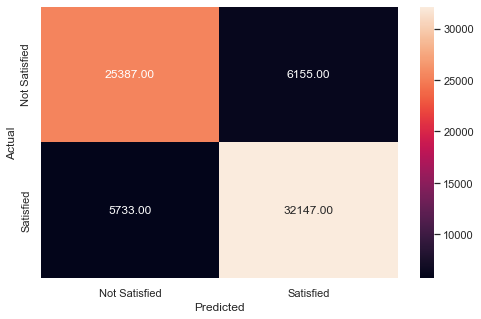

In [142]:

y_pred_train = lg.predict(X_train)

metrics_score(y_train, y_pred_train)

              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81      7799
         1.0       0.84      0.85      0.85      9557

    accuracy                           0.83     17356
   macro avg       0.83      0.83      0.83     17356
weighted avg       0.83      0.83      0.83     17356



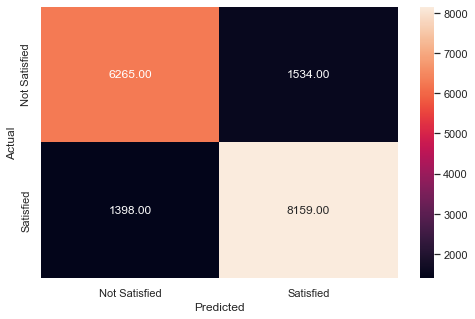

In [143]:
 y_pred_test = lg.predict(X_test)

metrics_score(y_test, y_pred_test)

Accuracy is 83% and needs imporving

## Support Vector Machines

In [145]:
from sklearn.svm import SVC

svm = SVC(kernel='linear') 
model = svm.fit(X= X_train, y = y_train)


              precision    recall  f1-score   support

         0.0       0.81      0.82      0.82     31542
         1.0       0.85      0.84      0.85     37880

    accuracy                           0.83     69422
   macro avg       0.83      0.83      0.83     69422
weighted avg       0.83      0.83      0.83     69422



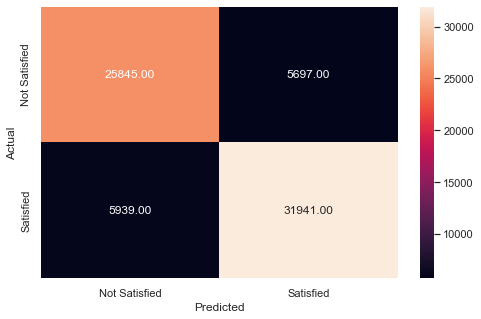

In [146]:
y_pred_train_svm = model.predict(X_train)

metrics_score(y_train, y_pred_train_svm)

              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82      7799
         1.0       0.85      0.85      0.85      9557

    accuracy                           0.84     17356
   macro avg       0.83      0.83      0.83     17356
weighted avg       0.84      0.84      0.84     17356



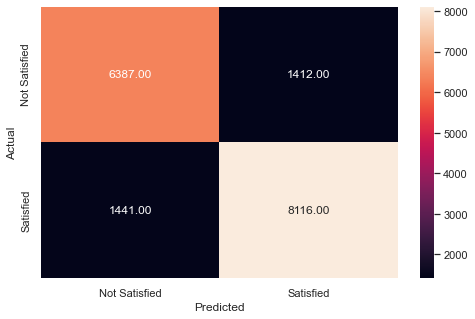

In [147]:
y_pred_test_svm = model.predict(X_test)

metrics_score(y_test, y_pred_test_svm)

rbf might be a better choice as kernel

In [148]:
svm_rbf = SVC(kernel='rbf')
model = svm_rbf.fit(X= X_train, y = y_train)

              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92     31542
         1.0       0.93      0.95      0.94     37880

    accuracy                           0.93     69422
   macro avg       0.93      0.93      0.93     69422
weighted avg       0.93      0.93      0.93     69422



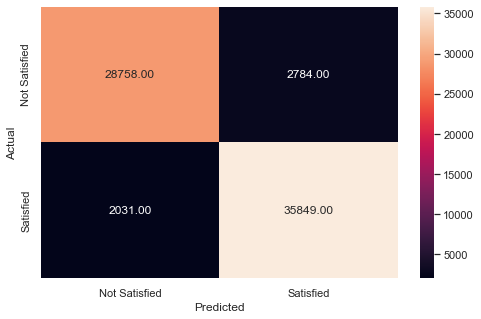

In [149]:
y_pred_train_rbf = model.predict(X_train)

metrics_score(y_train, y_pred_train_rbf)

              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92      7799
         1.0       0.92      0.95      0.93      9557

    accuracy                           0.93     17356
   macro avg       0.93      0.93      0.93     17356
weighted avg       0.93      0.93      0.93     17356



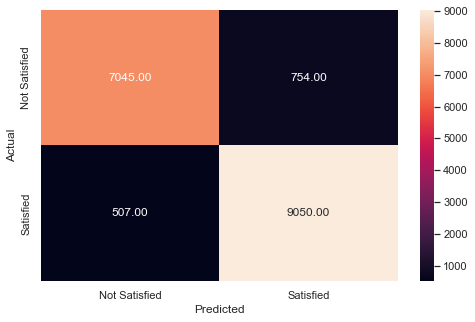

In [150]:
y_pred_test_rbf = model.predict(X_test)

metrics_score(y_test, y_pred_test_rbf)

93% accuracy is a very good performance, the model generalises well.

## Boosting

In [151]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='binary:hinge', colsample_bytree = 0.4, learning_rate = 0.1,
                max_depth = 20, alpha = 10, n_estimators = 60, random_state=42)
xg_model = xg_reg.fit(X= X_train, y = y_train)


              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95     31542
         1.0       0.96      0.96      0.96     37880

    accuracy                           0.96     69422
   macro avg       0.96      0.96      0.96     69422
weighted avg       0.96      0.96      0.96     69422



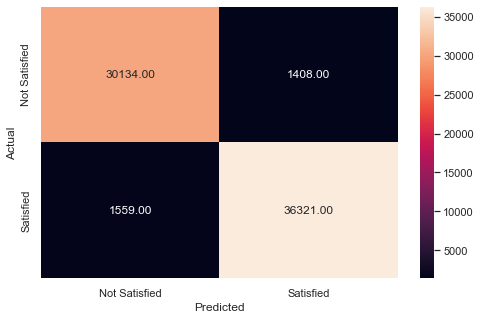

In [152]:
y_pred_train_xg = xg_model.predict(X_train)

metrics_score(y_train, y_pred_train_xg)

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      7799
         1.0       0.95      0.95      0.95      9557

    accuracy                           0.95     17356
   macro avg       0.95      0.95      0.95     17356
weighted avg       0.95      0.95      0.95     17356



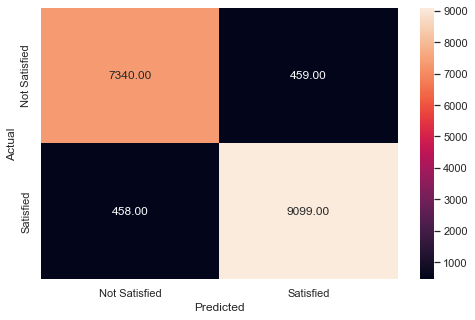

In [153]:
y_pred_test_xg = xg_model.predict(X_test)

metrics_score(y_test, y_pred_test_xg)

95% is enough to get passed into production and start testing on new and fresh data. Considering as well the very low computation time taken by XGBoost. Let's check feature importance according to it:

<AxesSubplot:xlabel='Importance'>

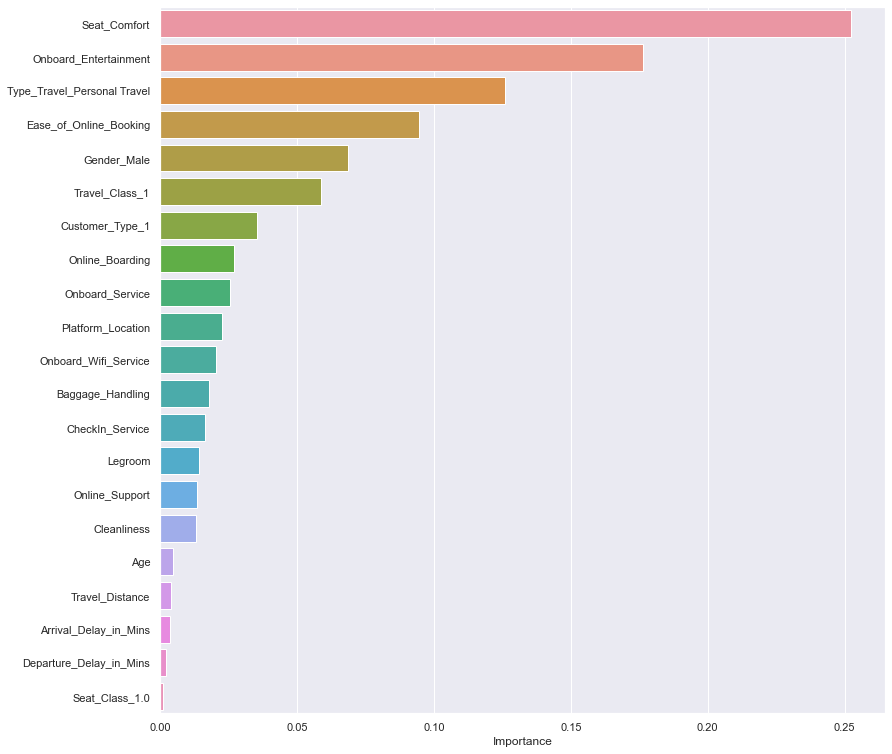

In [158]:

importances = xg_model.feature_importances_

columns = X_train.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_df.Importance,importance_df.index)

Seat Comfort seems to be the most important feature as well as onboard entertainment. Surprisingly, delay is very low ranked.

## Decision Trees

In [154]:
from sklearn.tree import DecisionTreeClassifier

model_dt= DecisionTreeClassifier(random_state=1,max_depth=20)
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, random_state=1)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     31542
         1.0       0.99      0.99      0.99     37880

    accuracy                           0.99     69422
   macro avg       0.99      0.99      0.99     69422
weighted avg       0.99      0.99      0.99     69422



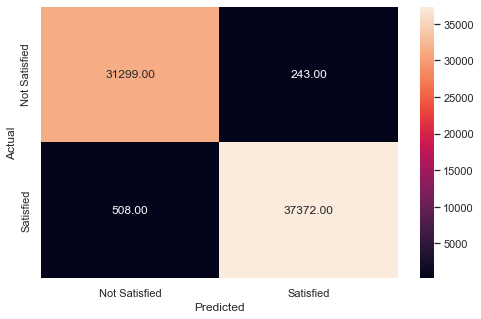

In [155]:

pred_train_dt = model_dt.predict(X_train)

metrics_score(y_train, pred_train_dt)

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      7799
         1.0       0.94      0.93      0.93      9557

    accuracy                           0.93     17356
   macro avg       0.93      0.93      0.93     17356
weighted avg       0.93      0.93      0.93     17356



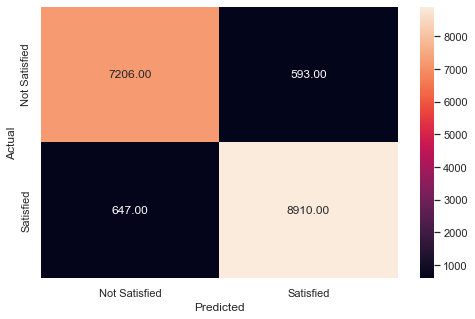

In [156]:
pred_test_dt = model_dt.predict(X_test)
metrics_score(y_test, pred_test_dt)

Decision Trees is giving good accuracy but is highly overfitting, we will then try next Random Forests algorithms. Lets see what features are most important accoring to decision trees:

<AxesSubplot:xlabel='Importance'>

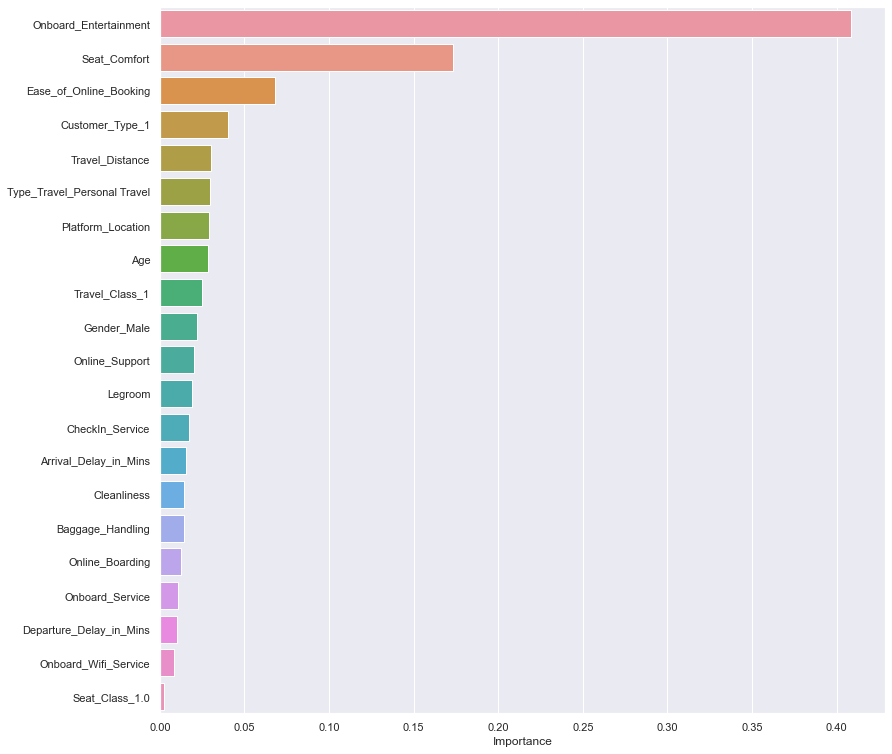

In [157]:

importances = model_dt.feature_importances_

columns = X_train.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_df.Importance,importance_df.index)

## Random Forest

In [271]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=150,max_depth=13, random_state=42, warm_start=True, criterion='gini', class_weight={0: 0.457, 1: 0.543})
rf.fit(X_train,y_train)


RandomForestClassifier(class_weight={0: 0.457, 1: 0.543}, max_depth=13,
                       n_estimators=150, random_state=42, warm_start=True)

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96     31542
         1.0       0.96      0.97      0.96     37880

    accuracy                           0.96     69422
   macro avg       0.96      0.96      0.96     69422
weighted avg       0.96      0.96      0.96     69422



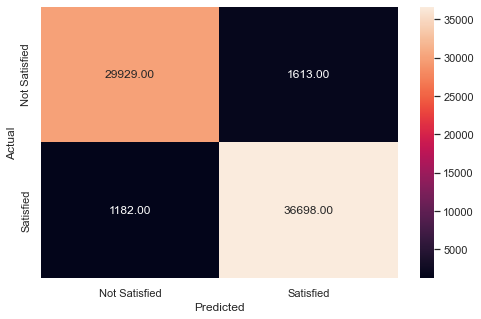

In [272]:
y_pred_train_rf = rf.predict(X_train)
metrics_score(y_train, y_pred_train_rf)


              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      7799
         1.0       0.94      0.93      0.93      9557

    accuracy                           0.93     17356
   macro avg       0.93      0.93      0.93     17356
weighted avg       0.93      0.93      0.93     17356



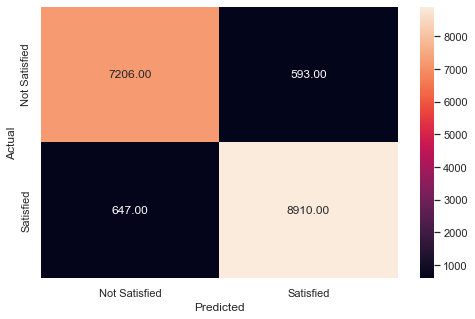

In [273]:
pred_test_rf = model_dt.predict(X_test)
metrics_score(y_test, pred_test_rf)

Very high overfitting, the model needs to be tunned inf order to generelize.

## Neural Networks

Lets build a first simple neural network with 2 Hidden Layers

### First neural network

In [191]:
# Initializing the ANN
model = Sequential()


model.add(Dense(activation = 'relu', input_dim = 21, units=128))

# Adding hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
# Adding the output layer
# We use the sigmoid because we want probability outcomes
model.add(Dense(1, activation = 'sigmoid')) 


In [192]:
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [193]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               2816      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 13,185
Trainable params: 13,185
Non-trainable params: 0
_________________________________________________________________


In [194]:
history = model.fit(X_train, y_train,           
          validation_split=0.2,
          epochs=70,
          batch_size=200,verbose=1)

Epoch 1/70
278/278 [==============================] - 1s 1ms/step - loss: 0.6260 - accuracy: 0.6568 - val_loss: 0.5646 - val_accuracy: 0.7276
Epoch 2/70
278/278 [==============================] - 0s 1ms/step - loss: 0.5166 - accuracy: 0.7618 - val_loss: 0.4749 - val_accuracy: 0.7880
Epoch 3/70
278/278 [==============================] - 0s 1ms/step - loss: 0.4496 - accuracy: 0.7988 - val_loss: 0.4254 - val_accuracy: 0.8124
Epoch 4/70
278/278 [==============================] - 0s 1ms/step - loss: 0.4107 - accuracy: 0.8205 - val_loss: 0.3971 - val_accuracy: 0.8282
Epoch 5/70
278/278 [==============================] - 0s 1ms/step - loss: 0.3882 - accuracy: 0.8343 - val_loss: 0.3811 - val_accuracy: 0.8385
Epoch 6/70
278/278 [==============================] - 0s 1ms/step - loss: 0.3745 - accuracy: 0.8409 - val_loss: 0.3705 - val_accuracy: 0.8443
Epoch 7/70
278/278 [==============================] - 0s 1ms/step - loss: 0.3643 - accuracy: 0.8470 - val_loss: 0.3615 - val_accuracy: 0.8486
Epoch 

278/278 [==============================] - 0s 976us/step - loss: 0.1852 - accuracy: 0.9231 - val_loss: 0.1880 - val_accuracy: 0.9223
Epoch 59/70
278/278 [==============================] - 0s 971us/step - loss: 0.1832 - accuracy: 0.9236 - val_loss: 0.2411 - val_accuracy: 0.8953
Epoch 60/70
278/278 [==============================] - 0s 983us/step - loss: 0.1865 - accuracy: 0.9222 - val_loss: 0.1852 - val_accuracy: 0.9227
Epoch 61/70
278/278 [==============================] - 0s 1ms/step - loss: 0.1805 - accuracy: 0.9245 - val_loss: 0.1837 - val_accuracy: 0.9239
Epoch 62/70
278/278 [==============================] - 0s 970us/step - loss: 0.1806 - accuracy: 0.9242 - val_loss: 0.1857 - val_accuracy: 0.9233
Epoch 63/70
278/278 [==============================] - 0s 990us/step - loss: 0.1796 - accuracy: 0.9251 - val_loss: 0.1929 - val_accuracy: 0.9205
Epoch 64/70
278/278 [==============================] - 0s 980us/step - loss: 0.1810 - accuracy: 0.9241 - val_loss: 0.1908 - val_accuracy: 0.9214

543/543 [==============================] - 0s 376us/step - loss: 0.1827 - accuracy: 0.9197


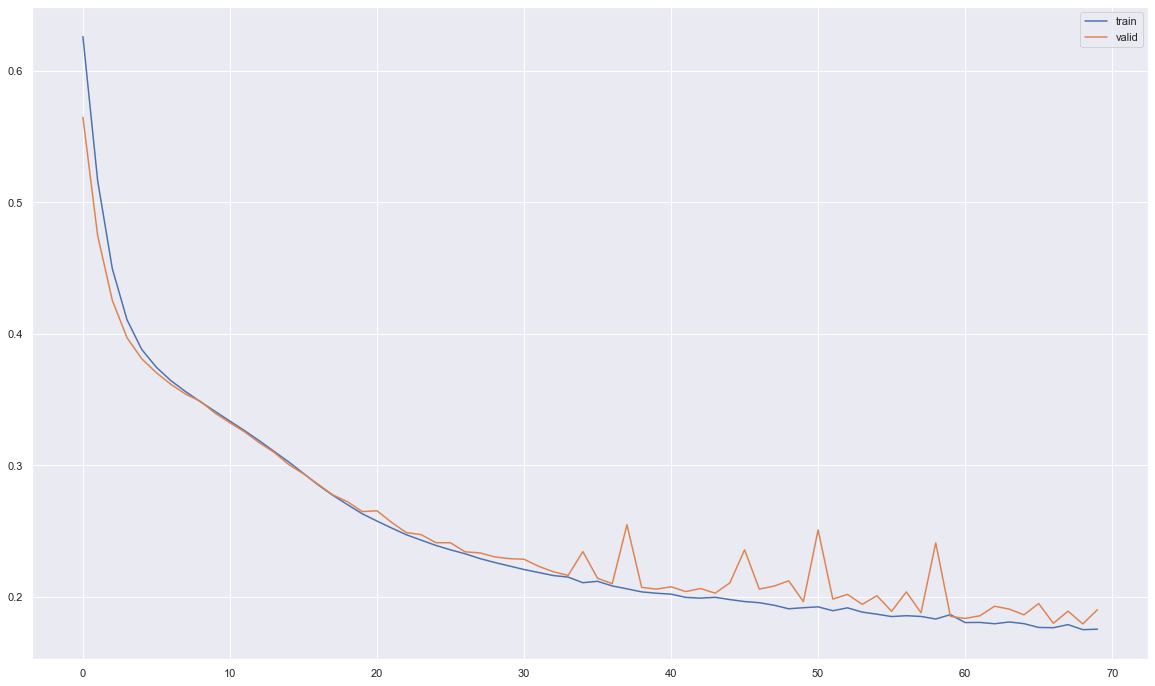

In [195]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

# Printing results
results = model.evaluate(X_test, y_test)

good news, not to much overfitting

In [196]:
# Predict probabilities
yhat = model.predict(X_test)

# Keep probabilities for the positive outcome only
yhat = yhat[:, 0]

# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# Locate the index of the largest g-mean
ix = np.argmax(gmeans)

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      7799
         1.0       0.94      0.92      0.93      9557

    accuracy                           0.93     17356
   macro avg       0.93      0.93      0.93     17356
weighted avg       0.93      0.93      0.93     17356



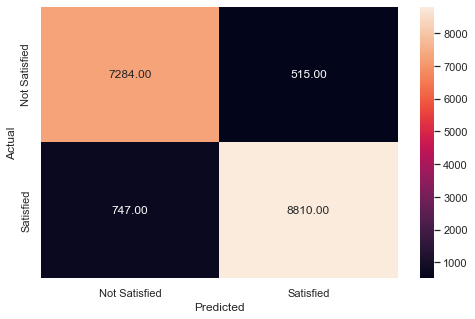

In [197]:
y_pred_e = model.predict(X_test)
y_pred_e = (y_pred_e > thresholds[ix])
metrics_score(y_test, y_pred_e)

...Unfortunately, accuracy is limited compaired to ML algorithms

In [199]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

### Batch normalization

batch normalization will help for regularization and reducing generalization error

In [200]:
model2 = Sequential()
model2.add(Dense(128,activation='relu',input_dim = X_train.shape[1]))
model2.add(BatchNormalization())
model2.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
model2.add(Dense(1, activation = 'sigmoid'))

In [201]:
optimizer = tf.keras.optimizers.Adam(0.001)
model2.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [202]:
history_2 = model2.fit(X_train, y_train, batch_size=64, epochs=100, verbose=0, validation_split = 0.2)

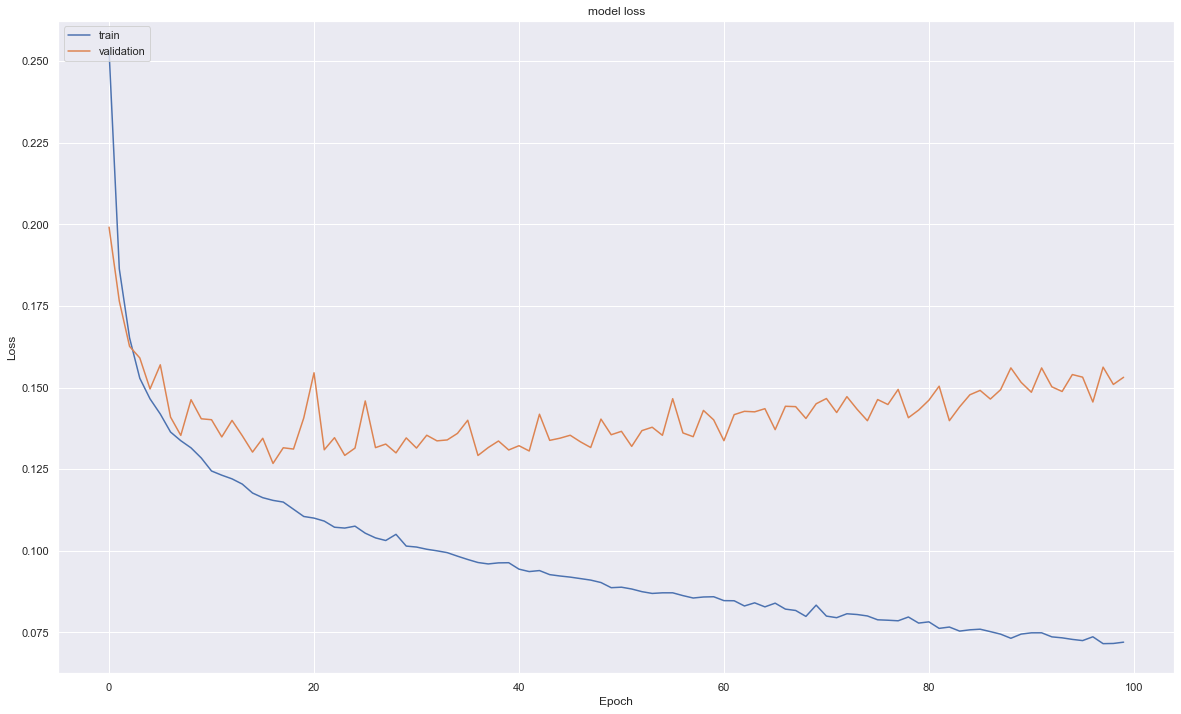

In [203]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])

plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Model is highly overfitting

Best Threshold=0.734134, G-Mean=0.947


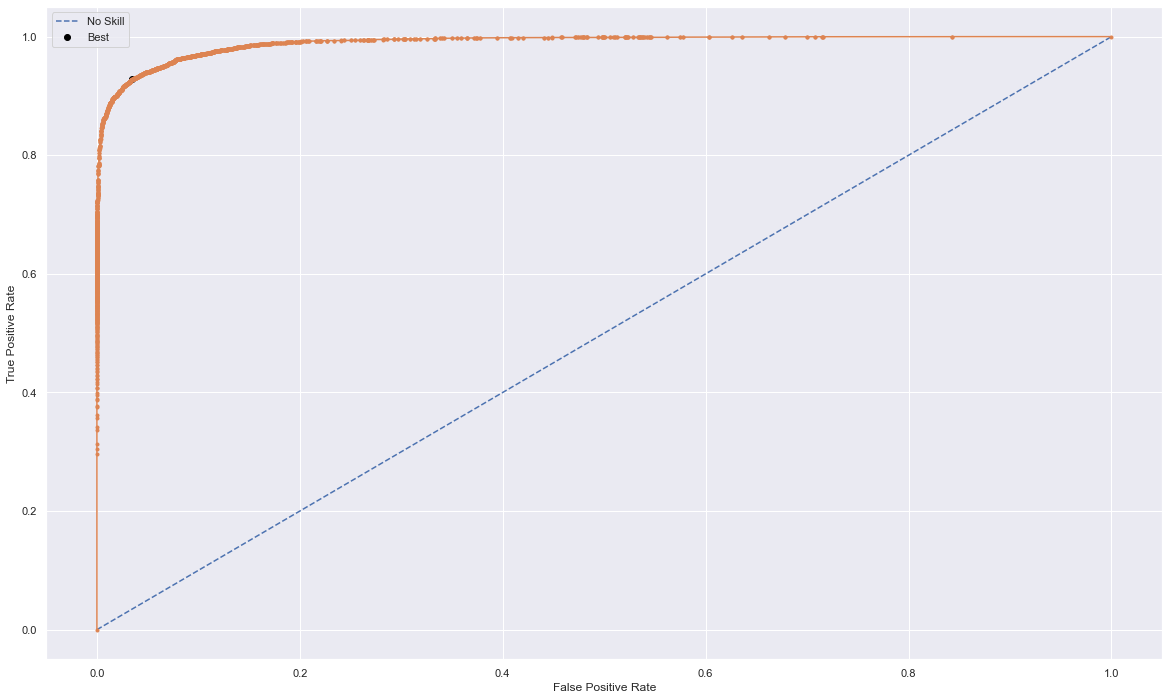

In [204]:


# Predict probabilities
yhat2 = model2.predict(X_test)

# Keep probabilities for the positive outcome only
yhat2 = yhat2[:, 0]

# Calculate roc curves
fpr, tpr, thresholds2 = roc_curve(y_test, yhat2)

# Calculate the g-mean for each threshold
gmeans2 = np.sqrt(tpr * (1-fpr))

# Locate the index of the largest g-mean
ix = np.argmax(gmeans2)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds2[ix], gmeans2[ix]))

# Plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# Axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# Show the plot
pyplot.show()

In [206]:
y_pred_e2 = model2.predict(X_test)
y_pred_e2 = (y_pred_e2 > thresholds2[ix])
y_pred_e2

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      7799
         1.0       0.97      0.93      0.95      9557

    accuracy                           0.94     17356
   macro avg       0.94      0.95      0.94     17356
weighted avg       0.95      0.94      0.95     17356



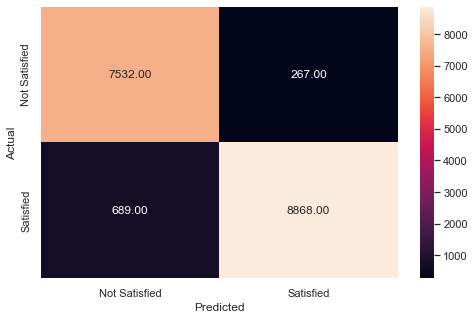

In [207]:
metrics_score(y_test, y_pred_e2)

This model is overfitting, nevertheless accuracy is high.

### Adding Dropout

Lets add dropout to reduce overfitting

In [252]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [253]:
model3 = Sequential()
model3.add(Dense(128,activation='relu',input_dim = X_train.shape[1]))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))
model3.add(Dense(64,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dense(32,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dense(1, activation = 'sigmoid'))


In [254]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2816      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                1

In [255]:
optimizer = tf.keras.optimizers.Adam(0.001)
model3.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])


In [256]:
history_3 = model3.fit(X_train, y_train, batch_size=90, epochs=100, verbose=1, validation_split = 0.2)

Epoch 1/100
618/618 [==============================] - 1s 2ms/step - loss: 0.3043 - accuracy: 0.8724 - val_loss: 0.2173 - val_accuracy: 0.9079
Epoch 2/100
618/618 [==============================] - 1s 1ms/step - loss: 0.2309 - accuracy: 0.9028 - val_loss: 0.1882 - val_accuracy: 0.9202
Epoch 3/100
618/618 [==============================] - 1s 1ms/step - loss: 0.2054 - accuracy: 0.9146 - val_loss: 0.1700 - val_accuracy: 0.9281
Epoch 4/100
618/618 [==============================] - 1s 1ms/step - loss: 0.1884 - accuracy: 0.9213 - val_loss: 0.1618 - val_accuracy: 0.9322
Epoch 5/100
618/618 [==============================] - 1s 1ms/step - loss: 0.1772 - accuracy: 0.9235 - val_loss: 0.1517 - val_accuracy: 0.9357
Epoch 6/100
618/618 [==============================] - 1s 1ms/step - loss: 0.1684 - accuracy: 0.9284 - val_loss: 0.1486 - val_accuracy: 0.9378
Epoch 7/100
618/618 [==============================] - 1s 1ms/step - loss: 0.1639 - accuracy: 0.9307 - val_loss: 0.1429 - val_accuracy: 0.9384

Epoch 58/100
618/618 [==============================] - 1s 1ms/step - loss: 0.1234 - accuracy: 0.9474 - val_loss: 0.1239 - val_accuracy: 0.9461
Epoch 59/100
618/618 [==============================] - 1s 1ms/step - loss: 0.1228 - accuracy: 0.9479 - val_loss: 0.1243 - val_accuracy: 0.9458
Epoch 60/100
618/618 [==============================] - 1s 1ms/step - loss: 0.1195 - accuracy: 0.9490 - val_loss: 0.1206 - val_accuracy: 0.9481
Epoch 61/100
618/618 [==============================] - 1s 1ms/step - loss: 0.1188 - accuracy: 0.9486 - val_loss: 0.1247 - val_accuracy: 0.9476
Epoch 62/100
618/618 [==============================] - 1s 1ms/step - loss: 0.1222 - accuracy: 0.9476 - val_loss: 0.1266 - val_accuracy: 0.9453
Epoch 63/100
618/618 [==============================] - 1s 1ms/step - loss: 0.1221 - accuracy: 0.9477 - val_loss: 0.1225 - val_accuracy: 0.9465
Epoch 64/100
618/618 [==============================] - 1s 1ms/step - loss: 0.1215 - accuracy: 0.9486 - val_loss: 0.1240 - val_accuracy:

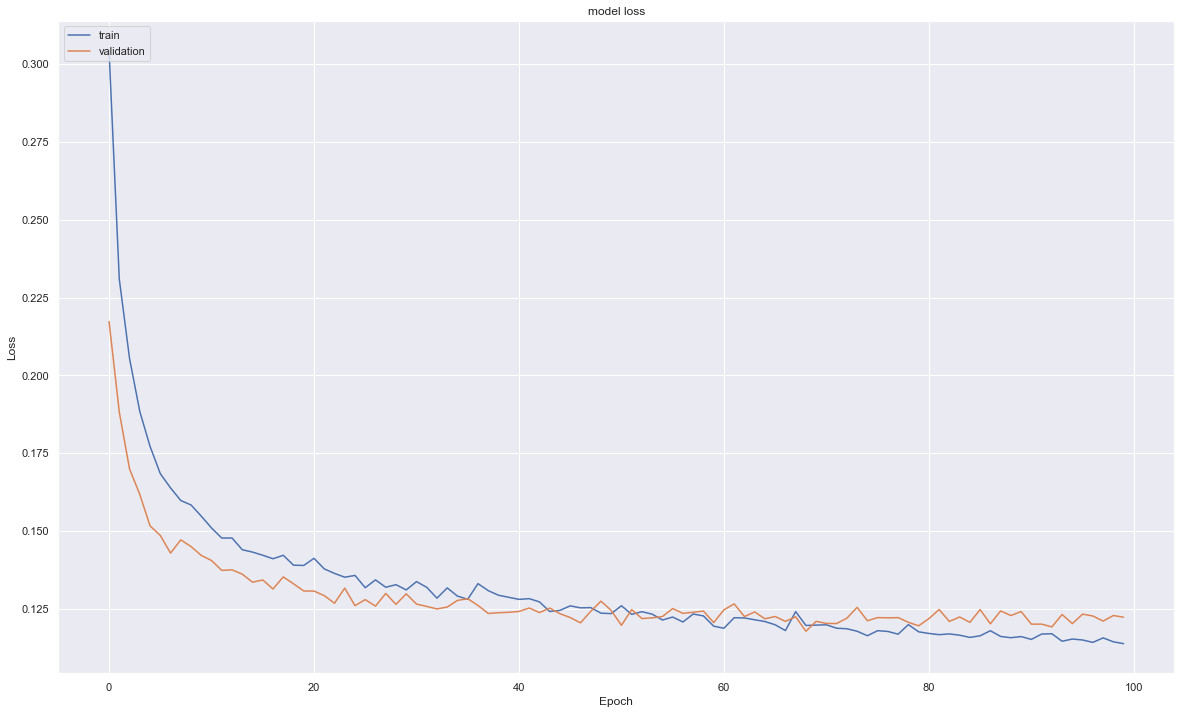

In [257]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])

plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Best Threshold=0.599029, G-Mean=0.951


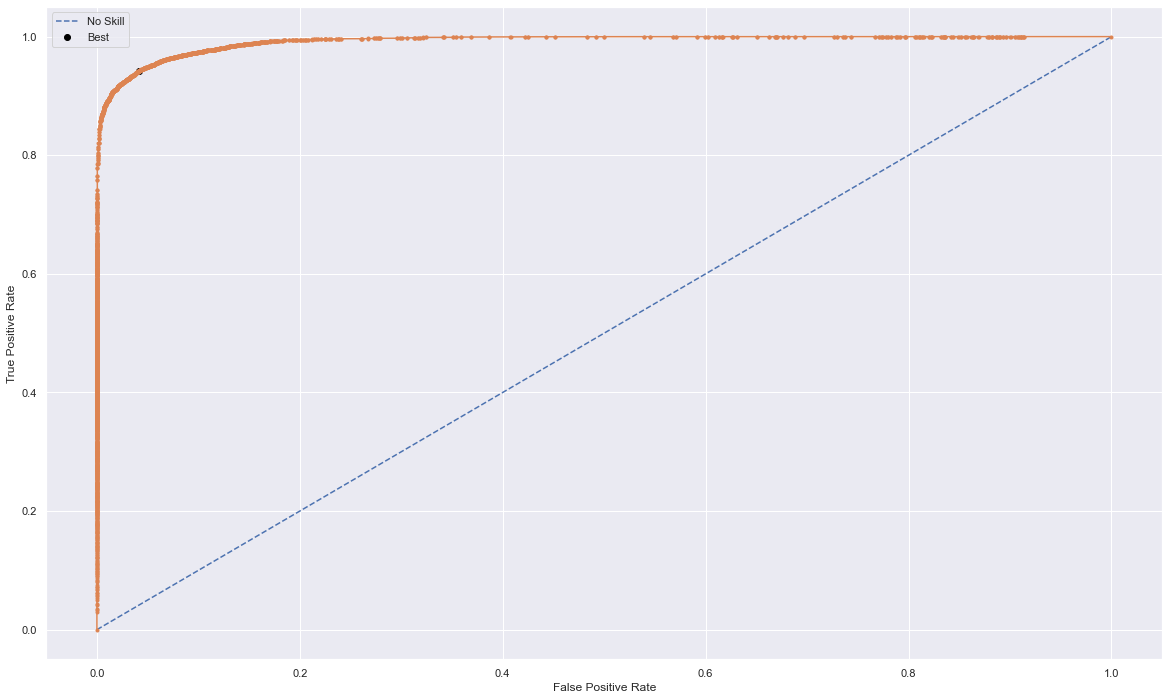

In [258]:
# Predict probabilities
yhat3 = model3.predict(X_test)

# Keep probabilities for the positive outcome only
yhat3 = yhat3[:, 0]

# Calculate roc curves
fpr, tpr, thresholds3 = roc_curve(y_test, yhat3)

# Calculate the g-mean for each threshold
gmeans3 = np.sqrt(tpr * (1-fpr))

# Locate the index of the largest g-mean
ix = np.argmax(gmeans3)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds3[ix], gmeans3[ix]))

# Plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# Axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# Show the plot
pyplot.show()

In [259]:
y_pred_e3 = model3.predict(X_test)
y_pred_e3 = (y_pred_e3 > thresholds3[ix])
y_pred_e3

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      7799
         1.0       0.97      0.94      0.95      9557

    accuracy                           0.95     17356
   macro avg       0.95      0.95      0.95     17356
weighted avg       0.95      0.95      0.95     17356



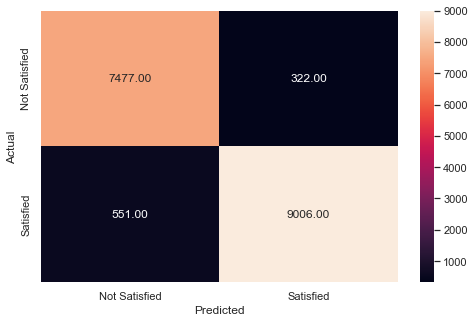

In [260]:
metrics_score(y_test, y_pred_e3)

This is the best neural network model yet, overfitting is very low and accuracy is beyond target. Lets try to tune it. Due to computational ressources during this time limited competition, tunning must be limited.

### Randomized search CV

In [261]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [262]:
def create_model_v4(lr,batch_size):  
    np.random.seed(1337)
    model4 = Sequential()
    model4.add(Dense(128,activation='relu',input_dim = X_train.shape[1]))
    model4.add(BatchNormalization())
    model4.add(Dropout(0.3))
    model4.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
    model4.add(BatchNormalization())
    model4.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
    model4.add(Dense(1, activation = 'sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model4.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model4

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model4.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [263]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

keras_estimator = KerasClassifier(build_fn=create_model_v4, verbose=1)

# Define the grid search parameters
param_random = {
    'batch_size':[90, 150],
    "lr":[0.001, 0.05],
    "epochs": [65, 90]}

kfold_splits = 5
random = RandomizedSearchCV(estimator=keras_estimator,  
                    verbose=1,
                    cv=kfold_splits,  
                    param_distributions=param_random,n_jobs=-1)

In [264]:
random_result = random.fit(X_train, y_train,validation_split=0.2,verbose=1) 

# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']

Fitting 5 folds for each of 8 candidates, totalling 40 fits


2022-09-01 01:32:59.948282: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-01 01:32:59.948282: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-01 01:32:59.949923: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropri

Epoch 1/65
494/494 [==============================] - 3s 4ms/step - loss: 0.2930 - accuracy: 0.8780 - val_loss: 0.2604 - val_accuracy: 0.8917
Epoch 2/65
494/494 [==============================] - 3s 4ms/step - loss: 0.3324 - accuracy: 0.8585 - val_loss: 0.2388 - val_accuracy: 0.8983
Epoch 2/65
494/494 [==============================] - 3s 4ms/step - loss: 0.2938 - accuracy: 0.8788 - val_loss: 0.5903 - val_accuracy: 0.8375
Epoch 2/65
494/494 [==============================] - 3s 4ms/step - loss: 0.3020 - accuracy: 0.8736 - val_loss: 0.5637 - val_accuracy: 0.8406
Epoch 2/65
494/494 [==============================] - 3s 4ms/step - loss: 0.3108 - accuracy: 0.8678 - val_loss: 0.2287 - val_accuracy: 0.9039
Epoch 2/65
494/494 [==============================] - 3s 4ms/step - loss: 0.3055 - accuracy: 0.8731 - val_loss: 0.3487 - val_accuracy: 0.8827
Epoch 2/65
494/494 [==============================] - 3s 4ms/step - loss: 0.3228 - accuracy: 0.8629 - val_loss: 0.2406 - val_accuracy: 0.8958
Epoch 

494/494 [==============================] - 2s 4ms/step - loss: 0.2255 - accuracy: 0.9047 - val_loss: 0.2117 - val_accuracy: 0.9145
Epoch 7/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1805 - accuracy: 0.9248 - val_loss: 0.1639 - val_accuracy: 0.9295
Epoch 7/65
494/494 [==============================] - 2s 4ms/step - loss: 0.2188 - accuracy: 0.9067 - val_loss: 0.2186 - val_accuracy: 0.9020
Epoch 7/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1784 - accuracy: 0.9239 - val_loss: 0.1638 - val_accuracy: 0.9305
Epoch 7/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1741 - accuracy: 0.9264 - val_loss: 0.1622 - val_accuracy: 0.9320
Epoch 7/65
494/494 [==============================] - 2s 4ms/step - loss: 0.2186 - accuracy: 0.9043 - val_loss: 0.1914 - val_accuracy: 0.9174
Epoch 7/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1706 - accuracy: 0.9273 - val_loss: 0.1493 - val_accuracy: 0.9369
Epoch 8/65
494/49

494/494 [==============================] - 2s 3ms/step - loss: 0.2210 - accuracy: 0.9003 - val_loss: 0.1982 - val_accuracy: 0.9032
Epoch 11/65
494/494 [==============================] - 2s 4ms/step - loss: 0.2012 - accuracy: 0.9158 - val_loss: 0.1717 - val_accuracy: 0.9187
Epoch 12/65
494/494 [==============================] - 2s 4ms/step - loss: 0.2029 - accuracy: 0.9117 - val_loss: 0.1824 - val_accuracy: 0.9250
Epoch 12/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1534 - accuracy: 0.9359 - val_loss: 0.1535 - val_accuracy: 0.9367
Epoch 12/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1558 - accuracy: 0.9349 - val_loss: 0.1563 - val_accuracy: 0.9324
Epoch 12/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1566 - accuracy: 0.9326 - val_loss: 0.1406 - val_accuracy: 0.9409
Epoch 12/65
494/494 [==============================] - 2s 4ms/step - loss: 0.2080 - accuracy: 0.9143 - val_loss: 0.1966 - val_accuracy: 0.9206
Epoch 12/65

494/494 [==============================] - 2s 4ms/step - loss: 0.1913 - accuracy: 0.9172 - val_loss: 0.2463 - val_accuracy: 0.8909
Epoch 17/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1461 - accuracy: 0.9371 - val_loss: 0.1420 - val_accuracy: 0.9383
Epoch 17/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1468 - accuracy: 0.9371 - val_loss: 0.1335 - val_accuracy: 0.9417
Epoch 17/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1446 - accuracy: 0.9380 - val_loss: 0.1491 - val_accuracy: 0.9359
Epoch 17/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1969 - accuracy: 0.9103 - val_loss: 0.1859 - val_accuracy: 0.9095
Epoch 17/65
494/494 [==============================] - 2s 3ms/step - loss: 0.2216 - accuracy: 0.9004 - val_loss: 0.2177 - val_accuracy: 0.9004
Epoch 17/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1902 - accuracy: 0.9177 - val_loss: 0.1625 - val_accuracy: 0.9228
Epoch 18/65

494/494 [==============================] - 2s 4ms/step - loss: 0.1935 - accuracy: 0.9178 - val_loss: 0.1978 - val_accuracy: 0.9149
Epoch 21/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1995 - accuracy: 0.9075 - val_loss: 0.1889 - val_accuracy: 0.9105
Epoch 21/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1398 - accuracy: 0.9402 - val_loss: 0.1400 - val_accuracy: 0.9375
Epoch 21/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1844 - accuracy: 0.9180 - val_loss: 0.1600 - val_accuracy: 0.9138
Epoch 22/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1950 - accuracy: 0.9159 - val_loss: 0.1730 - val_accuracy: 0.9202
Epoch 22/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1391 - accuracy: 0.9406 - val_loss: 0.1397 - val_accuracy: 0.9394
Epoch 22/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1377 - accuracy: 0.9417 - val_loss: 0.1398 - val_accuracy: 0.9411
Epoch 22/65

494/494 [==============================] - 2s 3ms/step - loss: 0.1355 - accuracy: 0.9421 - val_loss: 0.1263 - val_accuracy: 0.9419
Epoch 26/65
494/494 [==============================] - 2s 3ms/step - loss: 0.2077 - accuracy: 0.9034 - val_loss: 0.1905 - val_accuracy: 0.9129
Epoch 26/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1343 - accuracy: 0.9429 - val_loss: 0.1380 - val_accuracy: 0.9398
Epoch 27/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1906 - accuracy: 0.9154 - val_loss: 0.1873 - val_accuracy: 0.9189
Epoch 27/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1944 - accuracy: 0.9172 - val_loss: 0.1592 - val_accuracy: 0.9305
Epoch 27/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1343 - accuracy: 0.9428 - val_loss: 0.1341 - val_accuracy: 0.9406
Epoch 27/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1338 - accuracy: 0.9441 - val_loss: 0.1378 - val_accuracy: 0.9407
Epoch 27/65

494/494 [==============================] - 2s 4ms/step - loss: 0.1314 - accuracy: 0.9446 - val_loss: 0.1354 - val_accuracy: 0.9408
Epoch 31/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1941 - accuracy: 0.9130 - val_loss: 0.1910 - val_accuracy: 0.9211
Epoch 32/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1312 - accuracy: 0.9444 - val_loss: 0.1376 - val_accuracy: 0.9403
Epoch 32/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1885 - accuracy: 0.9212 - val_loss: 0.1594 - val_accuracy: 0.9319
Epoch 32/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1314 - accuracy: 0.9433 - val_loss: 0.1277 - val_accuracy: 0.9456
Epoch 32/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1300 - accuracy: 0.9447 - val_loss: 0.1400 - val_accuracy: 0.9411
Epoch 32/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1935 - accuracy: 0.9112 - val_loss: 0.1899 - val_accuracy: 0.9104
Epoch 32/65

494/494 [==============================] - 2s 4ms/step - loss: 0.1860 - accuracy: 0.9151 - val_loss: 0.1734 - val_accuracy: 0.9152
Epoch 35/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1262 - accuracy: 0.9459 - val_loss: 0.1396 - val_accuracy: 0.9403
Epoch 35/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1295 - accuracy: 0.9452 - val_loss: 0.1349 - val_accuracy: 0.9404
Epoch 36/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1921 - accuracy: 0.9143 - val_loss: 0.1800 - val_accuracy: 0.9104
Epoch 36/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1822 - accuracy: 0.9215 - val_loss: 0.1549 - val_accuracy: 0.9258
Epoch 36/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1290 - accuracy: 0.9438 - val_loss: 0.1250 - val_accuracy: 0.9443
Epoch 36/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1283 - accuracy: 0.9449 - val_loss: 0.1382 - val_accuracy: 0.9427
Epoch 36/65

494/494 [==============================] - 2s 3ms/step - loss: 0.1265 - accuracy: 0.9455 - val_loss: 0.1261 - val_accuracy: 0.9447
Epoch 40/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1268 - accuracy: 0.9463 - val_loss: 0.1397 - val_accuracy: 0.9404
Epoch 40/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1931 - accuracy: 0.9129 - val_loss: 0.1778 - val_accuracy: 0.9088
Epoch 40/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1860 - accuracy: 0.9188 - val_loss: 0.1760 - val_accuracy: 0.9256
Epoch 40/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1258 - accuracy: 0.9468 - val_loss: 0.1301 - val_accuracy: 0.9435
Epoch 41/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1837 - accuracy: 0.9218 - val_loss: 0.1612 - val_accuracy: 0.9276
Epoch 41/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1279 - accuracy: 0.9456 - val_loss: 0.1264 - val_accuracy: 0.9442
Epoch 41/65

494/494 [==============================] - 2s 4ms/step - loss: 0.1227 - accuracy: 0.9475 - val_loss: 0.1377 - val_accuracy: 0.9398
Epoch 45/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1248 - accuracy: 0.9464 - val_loss: 0.1369 - val_accuracy: 0.9424
Epoch 45/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1887 - accuracy: 0.9132 - val_loss: 0.1764 - val_accuracy: 0.9123
Epoch 45/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1818 - accuracy: 0.9226 - val_loss: 0.1710 - val_accuracy: 0.9235
Epoch 45/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1218 - accuracy: 0.9473 - val_loss: 0.1365 - val_accuracy: 0.9410
Epoch 45/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1227 - accuracy: 0.9474 - val_loss: 0.1288 - val_accuracy: 0.9433
Epoch 46/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1927 - accuracy: 0.9143 - val_loss: 0.1737 - val_accuracy: 0.9188
Epoch 46/65

494/494 [==============================] - 2s 3ms/step - loss: 0.1238 - accuracy: 0.9470 - val_loss: 0.1335 - val_accuracy: 0.9450
Epoch 49/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1224 - accuracy: 0.9486 - val_loss: 0.1333 - val_accuracy: 0.9407
Epoch 50/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1827 - accuracy: 0.9204 - val_loss: 0.1778 - val_accuracy: 0.9138
Epoch 50/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1815 - accuracy: 0.9212 - val_loss: 0.1845 - val_accuracy: 0.9309
Epoch 50/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1870 - accuracy: 0.9141 - val_loss: 0.1810 - val_accuracy: 0.9174
Epoch 50/65
494/494 [==============================] - 2s 4ms/step - loss: 0.1795 - accuracy: 0.9223 - val_loss: 0.1735 - val_accuracy: 0.9256
Epoch 50/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1204 - accuracy: 0.9475 - val_loss: 0.1300 - val_accuracy: 0.9427
Epoch 51/65

494/494 [==============================] - 2s 3ms/step - loss: 0.1191 - accuracy: 0.9485 - val_loss: 0.1354 - val_accuracy: 0.9409
Epoch 54/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1188 - accuracy: 0.9481 - val_loss: 0.1311 - val_accuracy: 0.9425
Epoch 55/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1186 - accuracy: 0.9490 - val_loss: 0.1283 - val_accuracy: 0.9451
Epoch 55/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1887 - accuracy: 0.9167 - val_loss: 0.1710 - val_accuracy: 0.9263
Epoch 55/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1180 - accuracy: 0.9497 - val_loss: 0.1219 - val_accuracy: 0.9467
Epoch 55/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1838 - accuracy: 0.9226 - val_loss: 0.1686 - val_accuracy: 0.9280
Epoch 55/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1179 - accuracy: 0.9500 - val_loss: 0.1303 - val_accuracy: 0.9418
Epoch 56/65

494/494 [==============================] - 2s 3ms/step - loss: 0.1204 - accuracy: 0.9481 - val_loss: 0.1211 - val_accuracy: 0.9445
Epoch 59/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1796 - accuracy: 0.9224 - val_loss: 0.1597 - val_accuracy: 0.9301
Epoch 59/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1816 - accuracy: 0.9154 - val_loss: 0.1699 - val_accuracy: 0.9246
Epoch 59/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1188 - accuracy: 0.9490 - val_loss: 0.1294 - val_accuracy: 0.9432
Epoch 59/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1163 - accuracy: 0.9500 - val_loss: 0.1273 - val_accuracy: 0.9437
Epoch 60/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1175 - accuracy: 0.9502 - val_loss: 0.1257 - val_accuracy: 0.9461
Epoch 60/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1185 - accuracy: 0.9492 - val_loss: 0.1261 - val_accuracy: 0.9450
Epoch 60/65

494/494 [==============================] - 2s 3ms/step - loss: 0.1169 - accuracy: 0.9494 - val_loss: 0.1184 - val_accuracy: 0.9465
Epoch 64/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1840 - accuracy: 0.9211 - val_loss: 0.1678 - val_accuracy: 0.9240
Epoch 64/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1155 - accuracy: 0.9495 - val_loss: 0.1315 - val_accuracy: 0.9443
Epoch 65/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1849 - accuracy: 0.9189 - val_loss: 0.1775 - val_accuracy: 0.9138
Epoch 65/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1179 - accuracy: 0.9483 - val_loss: 0.1192 - val_accuracy: 0.9462
Epoch 65/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1180 - accuracy: 0.9487 - val_loss: 0.1309 - val_accuracy: 0.9451
Epoch 65/65
494/494 [==============================] - 2s 3ms/step - loss: 0.1869 - accuracy: 0.9217 - val_loss: 0.1932 - val_accuracy: 0.9210
Epoch 65/65

494/494 [==============================] - 2s 3ms/step - loss: 0.2366 - accuracy: 0.9022 - val_loss: 0.2040 - val_accuracy: 0.9121
Epoch 3/90
494/494 [==============================] - 2s 4ms/step - loss: 0.2498 - accuracy: 0.8951 - val_loss: 0.2690 - val_accuracy: 0.8958
Epoch 3/90
494/494 [==============================] - 2s 4ms/step - loss: 0.2096 - accuracy: 0.9123 - val_loss: 0.1908 - val_accuracy: 0.9164
Epoch 4/90
494/494 [==============================] - 2s 4ms/step - loss: 0.2146 - accuracy: 0.9096 - val_loss: 0.1928 - val_accuracy: 0.9211
Epoch 4/90
494/494 [==============================] - 2s 4ms/step - loss: 0.2100 - accuracy: 0.9115 - val_loss: 0.1885 - val_accuracy: 0.9174
Epoch 4/90
494/494 [==============================] - 2s 4ms/step - loss: 0.2376 - accuracy: 0.8945 - val_loss: 0.2463 - val_accuracy: 0.8986
Epoch 4/90
494/494 [==============================] - 2s 4ms/step - loss: 0.2510 - accuracy: 0.8942 - val_loss: 0.2654 - val_accuracy: 0.9055
Epoch 4/90
494/49

494/494 [==============================] - 2s 4ms/step - loss: 0.2279 - accuracy: 0.9023 - val_loss: 0.2530 - val_accuracy: 0.8995
Epoch 7/90
494/494 [==============================] - 2s 3ms/step - loss: 0.2244 - accuracy: 0.9061 - val_loss: 0.2014 - val_accuracy: 0.9178
Epoch 7/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1684 - accuracy: 0.9284 - val_loss: 0.1601 - val_accuracy: 0.9349
Epoch 8/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1704 - accuracy: 0.9288 - val_loss: 0.1614 - val_accuracy: 0.9301
Epoch 8/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1708 - accuracy: 0.9281 - val_loss: 0.1638 - val_accuracy: 0.9251
Epoch 8/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1686 - accuracy: 0.9289 - val_loss: 0.1477 - val_accuracy: 0.9362
Epoch 8/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1687 - accuracy: 0.9277 - val_loss: 0.1624 - val_accuracy: 0.9292
Epoch 8/90
494/49

494/494 [==============================] - 2s 4ms/step - loss: 0.1571 - accuracy: 0.9339 - val_loss: 0.1527 - val_accuracy: 0.9344
Epoch 12/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1548 - accuracy: 0.9336 - val_loss: 0.1401 - val_accuracy: 0.9394
Epoch 12/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1533 - accuracy: 0.9352 - val_loss: 0.1514 - val_accuracy: 0.9359
Epoch 12/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1530 - accuracy: 0.9340 - val_loss: 0.1501 - val_accuracy: 0.9359
Epoch 13/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1522 - accuracy: 0.9346 - val_loss: 0.1401 - val_accuracy: 0.9399
Epoch 13/90
494/494 [==============================] - 2s 3ms/step - loss: 0.2003 - accuracy: 0.9112 - val_loss: 0.1981 - val_accuracy: 0.9164
Epoch 13/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1985 - accuracy: 0.9144 - val_loss: 0.1825 - val_accuracy: 0.9149
Epoch 13/90

494/494 [==============================] - 2s 4ms/step - loss: 0.2107 - accuracy: 0.9033 - val_loss: 0.2135 - val_accuracy: 0.8912
Epoch 16/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1435 - accuracy: 0.9396 - val_loss: 0.1428 - val_accuracy: 0.9355
Epoch 17/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1471 - accuracy: 0.9370 - val_loss: 0.1392 - val_accuracy: 0.9395
Epoch 17/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1445 - accuracy: 0.9381 - val_loss: 0.1466 - val_accuracy: 0.9361
Epoch 17/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1934 - accuracy: 0.9165 - val_loss: 0.1806 - val_accuracy: 0.9182
Epoch 17/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1952 - accuracy: 0.9135 - val_loss: 0.2058 - val_accuracy: 0.9044
Epoch 17/90
494/494 [==============================] - 2s 4ms/step - loss: 0.2021 - accuracy: 0.9141 - val_loss: 0.1899 - val_accuracy: 0.9186
Epoch 17/90

494/494 [==============================] - 2s 3ms/step - loss: 0.1388 - accuracy: 0.9408 - val_loss: 0.1385 - val_accuracy: 0.9381
Epoch 21/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1880 - accuracy: 0.9196 - val_loss: 0.1836 - val_accuracy: 0.9246
Epoch 21/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1915 - accuracy: 0.9131 - val_loss: 0.2008 - val_accuracy: 0.9085
Epoch 21/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1986 - accuracy: 0.9074 - val_loss: 0.1673 - val_accuracy: 0.9192
Epoch 21/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1406 - accuracy: 0.9395 - val_loss: 0.1382 - val_accuracy: 0.9392
Epoch 22/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1410 - accuracy: 0.9403 - val_loss: 0.1450 - val_accuracy: 0.9375
Epoch 22/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1386 - accuracy: 0.9398 - val_loss: 0.1385 - val_accuracy: 0.9396
Epoch 22/90

494/494 [==============================] - 2s 4ms/step - loss: 0.1954 - accuracy: 0.9179 - val_loss: 0.1832 - val_accuracy: 0.9228
Epoch 25/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1357 - accuracy: 0.9427 - val_loss: 0.1385 - val_accuracy: 0.9404
Epoch 26/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1347 - accuracy: 0.9419 - val_loss: 0.1298 - val_accuracy: 0.9431
Epoch 26/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1875 - accuracy: 0.9158 - val_loss: 0.2132 - val_accuracy: 0.9113
Epoch 26/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1932 - accuracy: 0.9150 - val_loss: 0.1848 - val_accuracy: 0.9129
Epoch 26/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1294 - accuracy: 0.9438 - val_loss: 0.1369 - val_accuracy: 0.9409
Epoch 27/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1958 - accuracy: 0.9083 - val_loss: 0.1813 - val_accuracy: 0.9027
Epoch 26/90

494/494 [==============================] - 2s 3ms/step - loss: 0.1330 - accuracy: 0.9425 - val_loss: 0.1371 - val_accuracy: 0.9403
Epoch 31/90
494/494 [==============================] - 2s 3ms/step - loss: 0.2014 - accuracy: 0.9088 - val_loss: 0.1720 - val_accuracy: 0.9187
Epoch 30/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1941 - accuracy: 0.9190 - val_loss: 0.1684 - val_accuracy: 0.9288
Epoch 30/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1324 - accuracy: 0.9435 - val_loss: 0.1352 - val_accuracy: 0.9426
Epoch 31/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1299 - accuracy: 0.9449 - val_loss: 0.1410 - val_accuracy: 0.9388
Epoch 31/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1920 - accuracy: 0.9210 - val_loss: 0.1803 - val_accuracy: 0.9195
Epoch 31/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1310 - accuracy: 0.9442 - val_loss: 0.1462 - val_accuracy: 0.9364
Epoch 32/90

494/494 [==============================] - 2s 3ms/step - loss: 0.1851 - accuracy: 0.9201 - val_loss: 0.1926 - val_accuracy: 0.9255
Epoch 35/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1838 - accuracy: 0.9170 - val_loss: 0.1730 - val_accuracy: 0.9193
Epoch 35/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1910 - accuracy: 0.9098 - val_loss: 0.1660 - val_accuracy: 0.9132
Epoch 35/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1904 - accuracy: 0.9188 - val_loss: 0.1834 - val_accuracy: 0.9161
Epoch 35/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1273 - accuracy: 0.9465 - val_loss: 0.1327 - val_accuracy: 0.9415
Epoch 36/90
494/494 [==============================] - 2s 4ms/step - loss: 0.2096 - accuracy: 0.9137 - val_loss: 0.1969 - val_accuracy: 0.9100
Epoch 36/90
494/494 [==============================] - 2s 3ms/step - loss: 0.2042 - accuracy: 0.9138 - val_loss: 0.1919 - val_accuracy: 0.9057
Epoch 36/90

494/494 [==============================] - 2s 3ms/step - loss: 0.1848 - accuracy: 0.9222 - val_loss: 0.2092 - val_accuracy: 0.9191
Epoch 39/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1249 - accuracy: 0.9464 - val_loss: 0.1209 - val_accuracy: 0.9479
Epoch 40/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1263 - accuracy: 0.9454 - val_loss: 0.1320 - val_accuracy: 0.9422
Epoch 40/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1837 - accuracy: 0.9178 - val_loss: 0.1719 - val_accuracy: 0.9185
Epoch 40/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1871 - accuracy: 0.9206 - val_loss: 0.1986 - val_accuracy: 0.9186
Epoch 40/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1813 - accuracy: 0.9164 - val_loss: 0.1615 - val_accuracy: 0.9236
Epoch 41/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1930 - accuracy: 0.9147 - val_loss: 0.1667 - val_accuracy: 0.9260
Epoch 40/90

494/494 [==============================] - 2s 3ms/step - loss: 0.1870 - accuracy: 0.9206 - val_loss: 0.1945 - val_accuracy: 0.9246
Epoch 44/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1807 - accuracy: 0.9224 - val_loss: 0.1702 - val_accuracy: 0.9217
Epoch 44/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1249 - accuracy: 0.9459 - val_loss: 0.1357 - val_accuracy: 0.9402
Epoch 45/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1222 - accuracy: 0.9481 - val_loss: 0.1340 - val_accuracy: 0.9428
Epoch 45/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1805 - accuracy: 0.9204 - val_loss: 0.1974 - val_accuracy: 0.9271
Epoch 45/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1213 - accuracy: 0.9483 - val_loss: 0.1314 - val_accuracy: 0.9417
Epoch 46/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1916 - accuracy: 0.9206 - val_loss: 0.1757 - val_accuracy: 0.9241
Epoch 45/90

494/494 [==============================] - 2s 3ms/step - loss: 0.1891 - accuracy: 0.9183 - val_loss: 0.1674 - val_accuracy: 0.9280
Epoch 48/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1204 - accuracy: 0.9485 - val_loss: 0.1161 - val_accuracy: 0.9483
Epoch 49/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1805 - accuracy: 0.9192 - val_loss: 0.1633 - val_accuracy: 0.9157
Epoch 49/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1814 - accuracy: 0.9227 - val_loss: 0.1774 - val_accuracy: 0.9228
Epoch 50/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1225 - accuracy: 0.9477 - val_loss: 0.1338 - val_accuracy: 0.9414
Epoch 50/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1800 - accuracy: 0.9193 - val_loss: 0.1710 - val_accuracy: 0.9292
Epoch 49/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1209 - accuracy: 0.9484 - val_loss: 0.1328 - val_accuracy: 0.9418
Epoch 50/90

494/494 [==============================] - 2s 3ms/step - loss: 0.1832 - accuracy: 0.9204 - val_loss: 0.1741 - val_accuracy: 0.9305
Epoch 53/90
494/494 [==============================] - 2s 3ms/step - loss: 0.2045 - accuracy: 0.9083 - val_loss: 0.1853 - val_accuracy: 0.9138
Epoch 53/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1195 - accuracy: 0.9482 - val_loss: 0.1316 - val_accuracy: 0.9425
Epoch 54/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1877 - accuracy: 0.9187 - val_loss: 0.1757 - val_accuracy: 0.9089
Epoch 54/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1177 - accuracy: 0.9490 - val_loss: 0.1331 - val_accuracy: 0.9436
Epoch 55/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1829 - accuracy: 0.9158 - val_loss: 0.1780 - val_accuracy: 0.9199
Epoch 54/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1968 - accuracy: 0.9119 - val_loss: 0.2169 - val_accuracy: 0.8970
Epoch 54/90

494/494 [==============================] - 2s 4ms/step - loss: 0.1166 - accuracy: 0.9504 - val_loss: 0.1319 - val_accuracy: 0.9422
Epoch 59/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1175 - accuracy: 0.9502 - val_loss: 0.1292 - val_accuracy: 0.9447
Epoch 59/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1825 - accuracy: 0.9205 - val_loss: 0.1822 - val_accuracy: 0.9204
Epoch 58/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1815 - accuracy: 0.9182 - val_loss: 0.1726 - val_accuracy: 0.9278
Epoch 58/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1819 - accuracy: 0.9221 - val_loss: 0.1951 - val_accuracy: 0.8987
Epoch 58/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1168 - accuracy: 0.9497 - val_loss: 0.1162 - val_accuracy: 0.9497
Epoch 59/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1153 - accuracy: 0.9509 - val_loss: 0.1306 - val_accuracy: 0.9430
Epoch 59/90

494/494 [==============================] - 2s 4ms/step - loss: 0.1151 - accuracy: 0.9508 - val_loss: 0.1306 - val_accuracy: 0.9432
Epoch 63/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1841 - accuracy: 0.9182 - val_loss: 0.1653 - val_accuracy: 0.9180
Epoch 62/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1185 - accuracy: 0.9484 - val_loss: 0.1311 - val_accuracy: 0.9438
Epoch 63/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1178 - accuracy: 0.9497 - val_loss: 0.1334 - val_accuracy: 0.9440
Epoch 64/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1881 - accuracy: 0.9194 - val_loss: 0.1601 - val_accuracy: 0.9320
Epoch 63/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1820 - accuracy: 0.9183 - val_loss: 0.1795 - val_accuracy: 0.9105
Epoch 63/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1172 - accuracy: 0.9496 - val_loss: 0.1175 - val_accuracy: 0.9473
Epoch 64/90

494/494 [==============================] - 2s 4ms/step - loss: 0.1156 - accuracy: 0.9505 - val_loss: 0.1306 - val_accuracy: 0.9419
Epoch 68/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1832 - accuracy: 0.9153 - val_loss: 0.1566 - val_accuracy: 0.9301
Epoch 67/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1855 - accuracy: 0.9196 - val_loss: 0.1865 - val_accuracy: 0.9272
Epoch 67/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1145 - accuracy: 0.9506 - val_loss: 0.1321 - val_accuracy: 0.9418
Epoch 68/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1159 - accuracy: 0.9508 - val_loss: 0.1149 - val_accuracy: 0.9499
Epoch 68/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1178 - accuracy: 0.9489 - val_loss: 0.1328 - val_accuracy: 0.9433
Epoch 68/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1846 - accuracy: 0.9175 - val_loss: 0.1675 - val_accuracy: 0.9127
Epoch 68/90

494/494 [==============================] - 2s 3ms/step - loss: 0.1880 - accuracy: 0.9149 - val_loss: 0.1864 - val_accuracy: 0.9176
Epoch 71/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1133 - accuracy: 0.9513 - val_loss: 0.1181 - val_accuracy: 0.9483
Epoch 72/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1149 - accuracy: 0.9507 - val_loss: 0.1291 - val_accuracy: 0.9441
Epoch 73/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1140 - accuracy: 0.9513 - val_loss: 0.1296 - val_accuracy: 0.9432
Epoch 73/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1768 - accuracy: 0.9207 - val_loss: 0.1565 - val_accuracy: 0.9307
Epoch 72/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1780 - accuracy: 0.9211 - val_loss: 0.1845 - val_accuracy: 0.9233
Epoch 72/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1157 - accuracy: 0.9507 - val_loss: 0.1309 - val_accuracy: 0.9428
Epoch 73/90

494/494 [==============================] - 2s 3ms/step - loss: 0.1893 - accuracy: 0.9178 - val_loss: 0.1815 - val_accuracy: 0.9105
Epoch 76/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1118 - accuracy: 0.9519 - val_loss: 0.1206 - val_accuracy: 0.9484
Epoch 77/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1103 - accuracy: 0.9520 - val_loss: 0.1311 - val_accuracy: 0.9431
Epoch 77/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1118 - accuracy: 0.9519 - val_loss: 0.1273 - val_accuracy: 0.9459
Epoch 78/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1933 - accuracy: 0.9187 - val_loss: 0.2096 - val_accuracy: 0.9109
Epoch 77/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1850 - accuracy: 0.9209 - val_loss: 0.1809 - val_accuracy: 0.9210
Epoch 77/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1838 - accuracy: 0.9178 - val_loss: 0.1677 - val_accuracy: 0.9156
Epoch 77/90

494/494 [==============================] - 2s 4ms/step - loss: 0.1120 - accuracy: 0.9519 - val_loss: 0.1318 - val_accuracy: 0.9446
Epoch 82/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1139 - accuracy: 0.9506 - val_loss: 0.1292 - val_accuracy: 0.9436
Epoch 81/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1108 - accuracy: 0.9523 - val_loss: 0.1168 - val_accuracy: 0.9478
Epoch 82/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1143 - accuracy: 0.9496 - val_loss: 0.1279 - val_accuracy: 0.9436
Epoch 82/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1108 - accuracy: 0.9519 - val_loss: 0.1282 - val_accuracy: 0.9431
Epoch 83/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1915 - accuracy: 0.9149 - val_loss: 0.1633 - val_accuracy: 0.9301
Epoch 81/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1723 - accuracy: 0.9205 - val_loss: 0.1575 - val_accuracy: 0.9282
Epoch 82/90

494/494 [==============================] - 2s 4ms/step - loss: 0.1751 - accuracy: 0.9217 - val_loss: 0.1612 - val_accuracy: 0.9265
Epoch 85/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1796 - accuracy: 0.9233 - val_loss: 0.1775 - val_accuracy: 0.9233
Epoch 85/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1831 - accuracy: 0.9181 - val_loss: 0.1543 - val_accuracy: 0.9287
Epoch 85/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1769 - accuracy: 0.9226 - val_loss: 0.1937 - val_accuracy: 0.9128
Epoch 85/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1100 - accuracy: 0.9516 - val_loss: 0.1121 - val_accuracy: 0.9504
Epoch 86/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1108 - accuracy: 0.9523 - val_loss: 0.1284 - val_accuracy: 0.9433
Epoch 86/90
494/494 [==============================] - 2s 4ms/step - loss: 0.1113 - accuracy: 0.9526 - val_loss: 0.1263 - val_accuracy: 0.9447
Epoch 87/90

494/494 [==============================] - 2s 3ms/step - loss: 0.1732 - accuracy: 0.9230 - val_loss: 0.1857 - val_accuracy: 0.9159
Epoch 89/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1133 - accuracy: 0.9512 - val_loss: 0.1269 - val_accuracy: 0.9459
Epoch 90/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1818 - accuracy: 0.9189 - val_loss: 0.1649 - val_accuracy: 0.9241
Epoch 90/90
494/494 [==============================] - 2s 3ms/step - loss: 0.1777 - accuracy: 0.9199 - val_loss: 0.1717 - val_accuracy: 0.9183
Epoch 90/90
494/494 [==============================] - 1s 3ms/step - loss: 0.1771 - accuracy: 0.9210 - val_loss: 0.1752 - val_accuracy: 0.9254
Epoch 90/90
297/297 [==============================] - 2s 4ms/step - loss: 0.3225 - accuracy: 0.8629 - val_loss: 0.3129 - val_accuracy: 0.8589
Epoch 2/65
297/297 [==============================] - 2s 4ms/step - loss: 0.3214 - accuracy: 0.8625 - val_loss: 0.2844 - val_accuracy: 0.8860
Epoch 2/65
2

297/297 [==============================] - 1s 5ms/step - loss: 0.2413 - accuracy: 0.8951 - val_loss: 0.5010 - val_accuracy: 0.8706
Epoch 3/65
297/297 [==============================] - 1s 5ms/step - loss: 0.2155 - accuracy: 0.9091 - val_loss: 0.1945 - val_accuracy: 0.9192
Epoch 4/65
297/297 [==============================] - 1s 5ms/step - loss: 0.2216 - accuracy: 0.9072 - val_loss: 0.2164 - val_accuracy: 0.9030
Epoch 4/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1940 - accuracy: 0.9185 - val_loss: 0.1882 - val_accuracy: 0.9226
Epoch 5/65
297/297 [==============================] - 1s 4ms/step - loss: 0.2214 - accuracy: 0.9043 - val_loss: 0.2449 - val_accuracy: 0.8963
Epoch 4/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1938 - accuracy: 0.9198 - val_loss: 0.1835 - val_accuracy: 0.9247
Epoch 5/65
297/297 [==============================] - 1s 4ms/step - loss: 0.2413 - accuracy: 0.8956 - val_loss: 0.7200 - val_accuracy: 0.7891
Epoch 3/65
297/29

297/297 [==============================] - 1s 5ms/step - loss: 0.1978 - accuracy: 0.9132 - val_loss: 0.2525 - val_accuracy: 0.9113
Epoch 8/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1916 - accuracy: 0.9179 - val_loss: 0.2341 - val_accuracy: 0.8989
Epoch 9/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1952 - accuracy: 0.9172 - val_loss: 0.2139 - val_accuracy: 0.9147
Epoch 9/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1618 - accuracy: 0.9307 - val_loss: 0.1545 - val_accuracy: 0.9347
Epoch 10/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1986 - accuracy: 0.9124 - val_loss: 0.2129 - val_accuracy: 0.9100
Epoch 9/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1930 - accuracy: 0.9150 - val_loss: 0.2034 - val_accuracy: 0.9033
Epoch 10/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1528 - accuracy: 0.9351 - val_loss: 0.1530 - val_accuracy: 0.9346
Epoch 12/65
297

297/297 [==============================] - 1s 5ms/step - loss: 0.1816 - accuracy: 0.9212 - val_loss: 0.1951 - val_accuracy: 0.9159
Epoch 13/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1463 - accuracy: 0.9374 - val_loss: 0.1474 - val_accuracy: 0.9367
Epoch 15/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1903 - accuracy: 0.9174 - val_loss: 0.1800 - val_accuracy: 0.9228
Epoch 14/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1875 - accuracy: 0.9151 - val_loss: 0.2049 - val_accuracy: 0.9124
Epoch 14/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1453 - accuracy: 0.9392 - val_loss: 0.1529 - val_accuracy: 0.9348
Epoch 15/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1853 - accuracy: 0.9215 - val_loss: 0.1828 - val_accuracy: 0.9196
Epoch 14/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1829 - accuracy: 0.9206 - val_loss: 0.2032 - val_accuracy: 0.9181
Epoch 14/65

297/297 [==============================] - 1s 4ms/step - loss: 0.1364 - accuracy: 0.9411 - val_loss: 0.1370 - val_accuracy: 0.9396
Epoch 20/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1774 - accuracy: 0.9234 - val_loss: 0.1737 - val_accuracy: 0.9261
Epoch 18/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1863 - accuracy: 0.9163 - val_loss: 0.1903 - val_accuracy: 0.9165
Epoch 17/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1374 - accuracy: 0.9404 - val_loss: 0.1305 - val_accuracy: 0.9426
Epoch 19/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1393 - accuracy: 0.9408 - val_loss: 0.1411 - val_accuracy: 0.9400
Epoch 20/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1385 - accuracy: 0.9406 - val_loss: 0.1463 - val_accuracy: 0.9372
Epoch 21/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1771 - accuracy: 0.9228 - val_loss: 0.1727 - val_accuracy: 0.9209
Epoch 19/65

297/297 [==============================] - 1s 5ms/step - loss: 0.1779 - accuracy: 0.9233 - val_loss: 0.1803 - val_accuracy: 0.9204
Epoch 23/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1705 - accuracy: 0.9228 - val_loss: 0.1597 - val_accuracy: 0.9314
Epoch 22/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1348 - accuracy: 0.9431 - val_loss: 0.1297 - val_accuracy: 0.9427
Epoch 24/65
297/297 [==============================] - 2s 5ms/step - loss: 0.1330 - accuracy: 0.9436 - val_loss: 0.1433 - val_accuracy: 0.9376
Epoch 25/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1313 - accuracy: 0.9434 - val_loss: 0.1370 - val_accuracy: 0.9400
Epoch 26/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1347 - accuracy: 0.9415 - val_loss: 0.1365 - val_accuracy: 0.9390
Epoch 25/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1772 - accuracy: 0.9235 - val_loss: 0.1658 - val_accuracy: 0.9262
Epoch 24/65

297/297 [==============================] - 1s 5ms/step - loss: 0.1709 - accuracy: 0.9271 - val_loss: 0.1835 - val_accuracy: 0.9199
Epoch 28/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1734 - accuracy: 0.9229 - val_loss: 0.1651 - val_accuracy: 0.9257
Epoch 28/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1800 - accuracy: 0.9215 - val_loss: 0.1575 - val_accuracy: 0.9310
Epoch 27/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1707 - accuracy: 0.9256 - val_loss: 0.1710 - val_accuracy: 0.9186
Epoch 29/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1739 - accuracy: 0.9245 - val_loss: 0.1736 - val_accuracy: 0.9221
Epoch 29/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1902 - accuracy: 0.9193 - val_loss: 0.1821 - val_accuracy: 0.9182
Epoch 29/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1294 - accuracy: 0.9438 - val_loss: 0.1354 - val_accuracy: 0.9407
Epoch 31/65

297/297 [==============================] - 1s 5ms/step - loss: 0.1713 - accuracy: 0.9252 - val_loss: 0.1722 - val_accuracy: 0.9260
Epoch 32/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1262 - accuracy: 0.9463 - val_loss: 0.1291 - val_accuracy: 0.9426
Epoch 33/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1765 - accuracy: 0.9251 - val_loss: 0.1886 - val_accuracy: 0.9200
Epoch 32/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1265 - accuracy: 0.9459 - val_loss: 0.1364 - val_accuracy: 0.9428
Epoch 34/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1790 - accuracy: 0.9241 - val_loss: 0.1674 - val_accuracy: 0.9242
Epoch 33/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1278 - accuracy: 0.9453 - val_loss: 0.1349 - val_accuracy: 0.9414
Epoch 35/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1253 - accuracy: 0.9450 - val_loss: 0.1371 - val_accuracy: 0.9398
Epoch 35/65

297/297 [==============================] - 1s 5ms/step - loss: 0.1256 - accuracy: 0.9451 - val_loss: 0.1349 - val_accuracy: 0.9398
Epoch 38/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1666 - accuracy: 0.9292 - val_loss: 0.2100 - val_accuracy: 0.9146
Epoch 37/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1238 - accuracy: 0.9471 - val_loss: 0.1259 - val_accuracy: 0.9442
Epoch 38/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1746 - accuracy: 0.9243 - val_loss: 0.1648 - val_accuracy: 0.9271
Epoch 37/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1232 - accuracy: 0.9471 - val_loss: 0.1349 - val_accuracy: 0.9403
Epoch 40/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1231 - accuracy: 0.9467 - val_loss: 0.1353 - val_accuracy: 0.9412
Epoch 40/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1706 - accuracy: 0.9263 - val_loss: 0.1780 - val_accuracy: 0.9228
Epoch 38/65

297/297 [==============================] - 1s 4ms/step - loss: 0.1764 - accuracy: 0.9239 - val_loss: 0.1888 - val_accuracy: 0.9241
Epoch 42/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1236 - accuracy: 0.9472 - val_loss: 0.1244 - val_accuracy: 0.9444
Epoch 43/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1695 - accuracy: 0.9255 - val_loss: 0.1534 - val_accuracy: 0.9307
Epoch 42/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1205 - accuracy: 0.9479 - val_loss: 0.1333 - val_accuracy: 0.9412
Epoch 44/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1786 - accuracy: 0.9225 - val_loss: 0.1748 - val_accuracy: 0.9219
Epoch 43/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1789 - accuracy: 0.9245 - val_loss: 0.4293 - val_accuracy: 0.8827
Epoch 42/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1186 - accuracy: 0.9482 - val_loss: 0.1231 - val_accuracy: 0.9459
Epoch 44/65

297/297 [==============================] - 1s 5ms/step - loss: 0.1654 - accuracy: 0.9279 - val_loss: 0.1641 - val_accuracy: 0.9262
Epoch 46/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1715 - accuracy: 0.9204 - val_loss: 0.1553 - val_accuracy: 0.9330
Epoch 48/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1186 - accuracy: 0.9475 - val_loss: 0.1243 - val_accuracy: 0.9457
Epoch 47/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1698 - accuracy: 0.9268 - val_loss: 0.1706 - val_accuracy: 0.9175
Epoch 46/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1691 - accuracy: 0.9275 - val_loss: 0.1649 - val_accuracy: 0.9308
Epoch 47/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1204 - accuracy: 0.9483 - val_loss: 0.1307 - val_accuracy: 0.9409
Epoch 48/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1185 - accuracy: 0.9494 - val_loss: 0.1359 - val_accuracy: 0.9431
Epoch 49/65

297/297 [==============================] - 1s 4ms/step - loss: 0.1205 - accuracy: 0.9484 - val_loss: 0.1290 - val_accuracy: 0.9423
Epoch 52/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1725 - accuracy: 0.9246 - val_loss: 0.1736 - val_accuracy: 0.9198
Epoch 51/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1674 - accuracy: 0.9278 - val_loss: 0.1835 - val_accuracy: 0.9290
Epoch 51/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1663 - accuracy: 0.9269 - val_loss: 0.1484 - val_accuracy: 0.9331
Epoch 50/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1658 - accuracy: 0.9280 - val_loss: 0.1592 - val_accuracy: 0.9298
Epoch 51/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1170 - accuracy: 0.9486 - val_loss: 0.1331 - val_accuracy: 0.9427
Epoch 54/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1174 - accuracy: 0.9492 - val_loss: 0.1226 - val_accuracy: 0.9461
Epoch 52/65

297/297 [==============================] - 1s 4ms/step - loss: 0.1174 - accuracy: 0.9497 - val_loss: 0.1313 - val_accuracy: 0.9435
Epoch 58/65
297/297 [==============================] - 1s 4ms/step - loss: 0.1622 - accuracy: 0.9288 - val_loss: 0.1707 - val_accuracy: 0.9263
Epoch 58/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1639 - accuracy: 0.9282 - val_loss: 0.1662 - val_accuracy: 0.9280
Epoch 56/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1697 - accuracy: 0.9280 - val_loss: 0.2928 - val_accuracy: 0.9301
Epoch 56/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1692 - accuracy: 0.9273 - val_loss: 0.1602 - val_accuracy: 0.9293
Epoch 56/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1174 - accuracy: 0.9492 - val_loss: 0.1336 - val_accuracy: 0.9400
Epoch 58/65
297/297 [==============================] - 1s 5ms/step - loss: 0.1699 - accuracy: 0.9263 - val_loss: 0.1601 - val_accuracy: 0.9178
Epoch 55/65

297/297 [==============================] - 2s 6ms/step - loss: 0.1724 - accuracy: 0.9279 - val_loss: 0.1719 - val_accuracy: 0.9273
Epoch 61/65
297/297 [==============================] - 2s 6ms/step - loss: 0.1156 - accuracy: 0.9501 - val_loss: 0.1311 - val_accuracy: 0.9420
Epoch 62/65
297/297 [==============================] - 2s 6ms/step - loss: 0.1630 - accuracy: 0.9314 - val_loss: 0.2326 - val_accuracy: 0.9289
Epoch 61/65
297/297 [==============================] - 2s 6ms/step - loss: 0.1146 - accuracy: 0.9510 - val_loss: 0.1218 - val_accuracy: 0.9457
Epoch 62/65
297/297 [==============================] - 2s 6ms/step - loss: 0.1124 - accuracy: 0.9519 - val_loss: 0.1326 - val_accuracy: 0.9421
Epoch 60/65
297/297 [==============================] - 2s 6ms/step - loss: 0.1655 - accuracy: 0.9283 - val_loss: 0.1799 - val_accuracy: 0.9243
Epoch 61/65
297/297 [==============================] - 2s 5ms/step - loss: 0.1709 - accuracy: 0.9278 - val_loss: 0.1681 - val_accuracy: 0.9276
Epoch 62/65

297/297 [==============================] - 2s 5ms/step - loss: 0.3831 - accuracy: 0.8366 - val_loss: 0.3118 - val_accuracy: 0.8679
Epoch 2/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1733 - accuracy: 0.9239 - val_loss: 0.1685 - val_accuracy: 0.9251
Epoch 65/65
297/297 [==============================] - 2s 4ms/step - loss: 0.3328 - accuracy: 0.8570 - val_loss: 0.2915 - val_accuracy: 0.8923
Epoch 2/90
297/297 [==============================] - 1s 4ms/step - loss: 0.2359 - accuracy: 0.9003 - val_loss: 0.2109 - val_accuracy: 0.9086
Epoch 3/90
297/297 [==============================] - 2s 5ms/step - loss: 0.3382 - accuracy: 0.8548 - val_loss: 0.3395 - val_accuracy: 0.8502
Epoch 2/90
297/297 [==============================] - 2s 6ms/step - loss: 0.3369 - accuracy: 0.8568 - val_loss: 0.2999 - val_accuracy: 0.8784
Epoch 2/90
297/297 [==============================] - 1s 4ms/step - loss: 0.2237 - accuracy: 0.9071 - val_loss: 0.2038 - val_accuracy: 0.9087
Epoch 4/90
297/2

297/297 [==============================] - 1s 5ms/step - loss: 0.2079 - accuracy: 0.9119 - val_loss: 0.1887 - val_accuracy: 0.9184
Epoch 5/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1772 - accuracy: 0.9248 - val_loss: 0.1669 - val_accuracy: 0.9304
Epoch 7/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1833 - accuracy: 0.9227 - val_loss: 0.1662 - val_accuracy: 0.9282
Epoch 7/90
297/297 [==============================] - 1s 4ms/step - loss: 0.2461 - accuracy: 0.8958 - val_loss: 0.3637 - val_accuracy: 0.8759
Epoch 3/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1960 - accuracy: 0.9158 - val_loss: 0.1780 - val_accuracy: 0.9230
Epoch 6/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1708 - accuracy: 0.9285 - val_loss: 0.1735 - val_accuracy: 0.9262
Epoch 8/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1766 - accuracy: 0.9261 - val_loss: 0.1681 - val_accuracy: 0.9285
Epoch 8/90
297/29

297/297 [==============================] - 1s 5ms/step - loss: 0.1935 - accuracy: 0.9184 - val_loss: 0.2326 - val_accuracy: 0.9153
Epoch 9/90
297/297 [==============================] - 1s 5ms/step - loss: 0.2007 - accuracy: 0.9134 - val_loss: 0.2083 - val_accuracy: 0.9178
Epoch 9/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1555 - accuracy: 0.9338 - val_loss: 0.1543 - val_accuracy: 0.9343
Epoch 12/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1870 - accuracy: 0.9196 - val_loss: 0.1678 - val_accuracy: 0.9227
Epoch 10/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1618 - accuracy: 0.9314 - val_loss: 0.1510 - val_accuracy: 0.9364
Epoch 10/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1989 - accuracy: 0.9149 - val_loss: 0.2540 - val_accuracy: 0.8936
Epoch 9/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1544 - accuracy: 0.9343 - val_loss: 0.1542 - val_accuracy: 0.9351
Epoch 12/90
29

297/297 [==============================] - 1s 5ms/step - loss: 0.1463 - accuracy: 0.9360 - val_loss: 0.1449 - val_accuracy: 0.9361
Epoch 16/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1819 - accuracy: 0.9229 - val_loss: 0.2381 - val_accuracy: 0.9047
Epoch 14/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1471 - accuracy: 0.9363 - val_loss: 0.1473 - val_accuracy: 0.9382
Epoch 15/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1869 - accuracy: 0.9205 - val_loss: 0.1785 - val_accuracy: 0.9198
Epoch 14/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1809 - accuracy: 0.9222 - val_loss: 0.1781 - val_accuracy: 0.9264
Epoch 14/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1808 - accuracy: 0.9216 - val_loss: 0.1686 - val_accuracy: 0.9300
Epoch 15/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1433 - accuracy: 0.9386 - val_loss: 0.1399 - val_accuracy: 0.9398
Epoch 17/90

297/297 [==============================] - 1s 4ms/step - loss: 0.1422 - accuracy: 0.9388 - val_loss: 0.1460 - val_accuracy: 0.9384
Epoch 19/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1413 - accuracy: 0.9400 - val_loss: 0.1421 - val_accuracy: 0.9359
Epoch 20/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1745 - accuracy: 0.9228 - val_loss: 0.1988 - val_accuracy: 0.9115
Epoch 18/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1413 - accuracy: 0.9401 - val_loss: 0.1368 - val_accuracy: 0.9397
Epoch 19/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1397 - accuracy: 0.9407 - val_loss: 0.1440 - val_accuracy: 0.9369
Epoch 21/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1821 - accuracy: 0.9219 - val_loss: 0.1705 - val_accuracy: 0.9246
Epoch 18/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1375 - accuracy: 0.9415 - val_loss: 0.1387 - val_accuracy: 0.9400
Epoch 21/90

297/297 [==============================] - 2s 6ms/step - loss: 0.1343 - accuracy: 0.9426 - val_loss: 0.1438 - val_accuracy: 0.9373
Epoch 25/90
297/297 [==============================] - 2s 6ms/step - loss: 0.1694 - accuracy: 0.9268 - val_loss: 0.1799 - val_accuracy: 0.9210
Epoch 24/90
297/297 [==============================] - 2s 6ms/step - loss: 0.1361 - accuracy: 0.9430 - val_loss: 0.1344 - val_accuracy: 0.9427
Epoch 24/90
297/297 [==============================] - 2s 8ms/step - loss: 0.1352 - accuracy: 0.9423 - val_loss: 0.1405 - val_accuracy: 0.9377
Epoch 24/90
297/297 [==============================] - 2s 6ms/step - loss: 0.1333 - accuracy: 0.9429 - val_loss: 0.1356 - val_accuracy: 0.9427
Epoch 26/90
297/297 [==============================] - 2s 6ms/step - loss: 0.1728 - accuracy: 0.9260 - val_loss: 0.1751 - val_accuracy: 0.9255
Epoch 23/90
297/297 [==============================] - 2s 6ms/step - loss: 0.1811 - accuracy: 0.9221 - val_loss: 0.1787 - val_accuracy: 0.9255
Epoch 23/90

297/297 [==============================] - 1s 5ms/step - loss: 0.1308 - accuracy: 0.9438 - val_loss: 0.1420 - val_accuracy: 0.9399
Epoch 29/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1336 - accuracy: 0.9437 - val_loss: 0.1327 - val_accuracy: 0.9444
Epoch 29/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1293 - accuracy: 0.9440 - val_loss: 0.1334 - val_accuracy: 0.9426
Epoch 29/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1276 - accuracy: 0.9454 - val_loss: 0.1374 - val_accuracy: 0.9406
Epoch 31/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1768 - accuracy: 0.9250 - val_loss: 0.1552 - val_accuracy: 0.9332
Epoch 28/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1837 - accuracy: 0.9209 - val_loss: 0.1865 - val_accuracy: 0.9262
Epoch 29/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1323 - accuracy: 0.9436 - val_loss: 0.1377 - val_accuracy: 0.9405
Epoch 30/90

297/297 [==============================] - 1s 4ms/step - loss: 0.1290 - accuracy: 0.9444 - val_loss: 0.1473 - val_accuracy: 0.9365
Epoch 34/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1254 - accuracy: 0.9458 - val_loss: 0.1329 - val_accuracy: 0.9429
Epoch 36/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1277 - accuracy: 0.9462 - val_loss: 0.1377 - val_accuracy: 0.9415
Epoch 35/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1261 - accuracy: 0.9452 - val_loss: 0.1361 - val_accuracy: 0.9391
Epoch 36/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1286 - accuracy: 0.9456 - val_loss: 0.1251 - val_accuracy: 0.9437
Epoch 34/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1749 - accuracy: 0.9254 - val_loss: 0.1706 - val_accuracy: 0.9251
Epoch 33/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1684 - accuracy: 0.9287 - val_loss: 0.1576 - val_accuracy: 0.9337
Epoch 34/90

297/297 [==============================] - 1s 4ms/step - loss: 0.1675 - accuracy: 0.9274 - val_loss: 0.1635 - val_accuracy: 0.9302
Epoch 38/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1258 - accuracy: 0.9460 - val_loss: 0.1262 - val_accuracy: 0.9452
Epoch 39/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1245 - accuracy: 0.9465 - val_loss: 0.1289 - val_accuracy: 0.9435
Epoch 41/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1247 - accuracy: 0.9461 - val_loss: 0.1351 - val_accuracy: 0.9436
Epoch 39/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1229 - accuracy: 0.9492 - val_loss: 0.1339 - val_accuracy: 0.9431
Epoch 40/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1639 - accuracy: 0.9293 - val_loss: 0.1685 - val_accuracy: 0.9227
Epoch 39/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1257 - accuracy: 0.9469 - val_loss: 0.1343 - val_accuracy: 0.9415
Epoch 41/90

297/297 [==============================] - 1s 4ms/step - loss: 0.1719 - accuracy: 0.9268 - val_loss: 0.1621 - val_accuracy: 0.9243
Epoch 42/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1704 - accuracy: 0.9289 - val_loss: 0.1632 - val_accuracy: 0.9346
Epoch 41/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1667 - accuracy: 0.9299 - val_loss: 0.1642 - val_accuracy: 0.9310
Epoch 43/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1649 - accuracy: 0.9306 - val_loss: 0.1608 - val_accuracy: 0.9324
Epoch 44/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1723 - accuracy: 0.9236 - val_loss: 0.1639 - val_accuracy: 0.9266
Epoch 43/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1743 - accuracy: 0.9286 - val_loss: 0.1538 - val_accuracy: 0.9348
Epoch 42/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1701 - accuracy: 0.9292 - val_loss: 0.1559 - val_accuracy: 0.9314
Epoch 43/90

297/297 [==============================] - 1s 4ms/step - loss: 0.1199 - accuracy: 0.9483 - val_loss: 0.1325 - val_accuracy: 0.9440
Epoch 50/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1206 - accuracy: 0.9484 - val_loss: 0.1223 - val_accuracy: 0.9486
Epoch 48/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1190 - accuracy: 0.9494 - val_loss: 0.1308 - val_accuracy: 0.9427
Epoch 50/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1739 - accuracy: 0.9262 - val_loss: 0.1683 - val_accuracy: 0.9308
Epoch 46/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1763 - accuracy: 0.9255 - val_loss: 0.1527 - val_accuracy: 0.9345
Epoch 47/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1682 - accuracy: 0.9286 - val_loss: 0.1664 - val_accuracy: 0.9298
Epoch 48/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1194 - accuracy: 0.9489 - val_loss: 0.1235 - val_accuracy: 0.9465
Epoch 49/90

297/297 [==============================] - 1s 4ms/step - loss: 0.1699 - accuracy: 0.9291 - val_loss: 0.1688 - val_accuracy: 0.9288
Epoch 50/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1178 - accuracy: 0.9491 - val_loss: 0.1297 - val_accuracy: 0.9454
Epoch 55/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1196 - accuracy: 0.9492 - val_loss: 0.1375 - val_accuracy: 0.9396
Epoch 53/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1198 - accuracy: 0.9489 - val_loss: 0.1354 - val_accuracy: 0.9397
Epoch 54/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1186 - accuracy: 0.9491 - val_loss: 0.1202 - val_accuracy: 0.9480
Epoch 53/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1175 - accuracy: 0.9489 - val_loss: 0.1307 - val_accuracy: 0.9430
Epoch 55/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1627 - accuracy: 0.9315 - val_loss: 0.1592 - val_accuracy: 0.9293
Epoch 53/90

297/297 [==============================] - 1s 4ms/step - loss: 0.1160 - accuracy: 0.9502 - val_loss: 0.1305 - val_accuracy: 0.9426
Epoch 59/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1759 - accuracy: 0.9253 - val_loss: 0.1627 - val_accuracy: 0.9242
Epoch 55/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1610 - accuracy: 0.9305 - val_loss: 0.1593 - val_accuracy: 0.9304
Epoch 57/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1734 - accuracy: 0.9264 - val_loss: 0.1612 - val_accuracy: 0.9231
Epoch 56/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1676 - accuracy: 0.9290 - val_loss: 0.1788 - val_accuracy: 0.9182
Epoch 56/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1626 - accuracy: 0.9300 - val_loss: 0.1516 - val_accuracy: 0.9370
Epoch 57/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1165 - accuracy: 0.9499 - val_loss: 0.1309 - val_accuracy: 0.9440
Epoch 60/90

297/297 [==============================] - 1s 4ms/step - loss: 0.1156 - accuracy: 0.9495 - val_loss: 0.1280 - val_accuracy: 0.9435
Epoch 63/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1162 - accuracy: 0.9503 - val_loss: 0.1347 - val_accuracy: 0.9422
Epoch 62/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1695 - accuracy: 0.9279 - val_loss: 0.1751 - val_accuracy: 0.9307
Epoch 60/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1678 - accuracy: 0.9279 - val_loss: 0.1598 - val_accuracy: 0.9283
Epoch 62/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1189 - accuracy: 0.9489 - val_loss: 0.1302 - val_accuracy: 0.9415
Epoch 65/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1172 - accuracy: 0.9495 - val_loss: 0.1349 - val_accuracy: 0.9418
Epoch 63/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1154 - accuracy: 0.9495 - val_loss: 0.1279 - val_accuracy: 0.9436
Epoch 64/90

297/297 [==============================] - 2s 6ms/step - loss: 0.1644 - accuracy: 0.9306 - val_loss: 0.1480 - val_accuracy: 0.9364
Epoch 65/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1136 - accuracy: 0.9506 - val_loss: 0.1291 - val_accuracy: 0.9449
Epoch 69/90
297/297 [==============================] - 2s 5ms/step - loss: 0.1135 - accuracy: 0.9514 - val_loss: 0.1180 - val_accuracy: 0.9481
Epoch 67/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1127 - accuracy: 0.9512 - val_loss: 0.1316 - val_accuracy: 0.9443
Epoch 69/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1140 - accuracy: 0.9507 - val_loss: 0.1321 - val_accuracy: 0.9433
Epoch 67/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1666 - accuracy: 0.9271 - val_loss: 0.1576 - val_accuracy: 0.9216
Epoch 66/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1607 - accuracy: 0.9312 - val_loss: 0.1591 - val_accuracy: 0.9283
Epoch 66/90

297/297 [==============================] - 1s 4ms/step - loss: 0.1669 - accuracy: 0.9259 - val_loss: 0.1783 - val_accuracy: 0.9193
Epoch 70/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1666 - accuracy: 0.9299 - val_loss: 0.1783 - val_accuracy: 0.9298
Epoch 70/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1127 - accuracy: 0.9509 - val_loss: 0.1328 - val_accuracy: 0.9436
Epoch 72/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1657 - accuracy: 0.9260 - val_loss: 0.1822 - val_accuracy: 0.9189
Epoch 71/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1103 - accuracy: 0.9539 - val_loss: 0.1170 - val_accuracy: 0.9489
Epoch 73/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1103 - accuracy: 0.9530 - val_loss: 0.1297 - val_accuracy: 0.9439
Epoch 75/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1697 - accuracy: 0.9281 - val_loss: 0.1814 - val_accuracy: 0.9236
Epoch 71/90

297/297 [==============================] - 1s 5ms/step - loss: 0.1607 - accuracy: 0.9309 - val_loss: 0.1716 - val_accuracy: 0.9279
Epoch 75/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1109 - accuracy: 0.9519 - val_loss: 0.1270 - val_accuracy: 0.9465
Epoch 78/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1694 - accuracy: 0.9283 - val_loss: 0.1616 - val_accuracy: 0.9281
Epoch 75/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1648 - accuracy: 0.9309 - val_loss: 0.1835 - val_accuracy: 0.9153
Epoch 74/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1136 - accuracy: 0.9512 - val_loss: 0.1331 - val_accuracy: 0.9422
Epoch 77/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1105 - accuracy: 0.9526 - val_loss: 0.1210 - val_accuracy: 0.9472
Epoch 76/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1089 - accuracy: 0.9533 - val_loss: 0.1306 - val_accuracy: 0.9422
Epoch 78/90

297/297 [==============================] - 1s 5ms/step - loss: 0.1884 - accuracy: 0.9217 - val_loss: 0.1721 - val_accuracy: 0.9334
Epoch 78/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1641 - accuracy: 0.9294 - val_loss: 0.1671 - val_accuracy: 0.9202
Epoch 80/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1110 - accuracy: 0.9521 - val_loss: 0.1334 - val_accuracy: 0.9432
Epoch 81/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1092 - accuracy: 0.9534 - val_loss: 0.1316 - val_accuracy: 0.9438
Epoch 83/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1606 - accuracy: 0.9286 - val_loss: 0.1650 - val_accuracy: 0.9313
Epoch 81/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1098 - accuracy: 0.9533 - val_loss: 0.1282 - val_accuracy: 0.9437
Epoch 83/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1721 - accuracy: 0.9280 - val_loss: 0.1460 - val_accuracy: 0.9355
Epoch 80/90

Epoch 86/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1600 - accuracy: 0.9307 - val_loss: 0.1656 - val_accuracy: 0.9321
Epoch 84/90
297/297 [==============================] - 1s 4ms/step - loss: 0.1097 - accuracy: 0.9537 - val_loss: 0.1286 - val_accuracy: 0.9458
Epoch 87/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1629 - accuracy: 0.9303 - val_loss: 0.1483 - val_accuracy: 0.9347
Epoch 84/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1100 - accuracy: 0.9526 - val_loss: 0.1319 - val_accuracy: 0.9432
Epoch 86/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1097 - accuracy: 0.9530 - val_loss: 0.1203 - val_accuracy: 0.9486
Epoch 85/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1699 - accuracy: 0.9294 - val_loss: 0.1610 - val_accuracy: 0.9304
Epoch 83/90
297/297 [==============================] - 1s 5ms/step - loss: 0.1104 - accuracy: 0.9521 - val_loss: 0.1344 - val_accuracy: 0.9441

297/297 [==============================] - 1s 4ms/step - loss: 0.1684 - accuracy: 0.9255 - val_loss: 0.1653 - val_accuracy: 0.9246
Epoch 88/90
297/297 [==============================] - 1s 3ms/step - loss: 0.1592 - accuracy: 0.9321 - val_loss: 0.1510 - val_accuracy: 0.9350
Epoch 88/90
297/297 [==============================] - 1s 3ms/step - loss: 0.1601 - accuracy: 0.9309 - val_loss: 0.1614 - val_accuracy: 0.9314
Epoch 90/90
297/297 [==============================] - 1s 3ms/step - loss: 0.1565 - accuracy: 0.9337 - val_loss: 0.1517 - val_accuracy: 0.9362
Epoch 90/90
297/297 [==============================] - 1s 3ms/step - loss: 0.1611 - accuracy: 0.9323 - val_loss: 0.1541 - val_accuracy: 0.9338
Epoch 89/90
297/297 [==============================] - 1s 3ms/step - loss: 0.1745 - accuracy: 0.9271 - val_loss: 0.1658 - val_accuracy: 0.9350
Epoch 89/90
297/297 [==============================] - 1s 2ms/step - loss: 0.1661 - accuracy: 0.9279 - val_loss: 0.1438 - val_accuracy: 0.9363
Epoch 90/90

618/618 [==============================] - 1s 1ms/step - loss: 0.1339 - accuracy: 0.9428 - val_loss: 0.1316 - val_accuracy: 0.9440
Epoch 26/90
618/618 [==============================] - 1s 1ms/step - loss: 0.1307 - accuracy: 0.9443 - val_loss: 0.1281 - val_accuracy: 0.9448
Epoch 27/90
618/618 [==============================] - 1s 1ms/step - loss: 0.1333 - accuracy: 0.9431 - val_loss: 0.1310 - val_accuracy: 0.9412
Epoch 28/90
618/618 [==============================] - 1s 1ms/step - loss: 0.1306 - accuracy: 0.9451 - val_loss: 0.1293 - val_accuracy: 0.9452
Epoch 29/90
618/618 [==============================] - 1s 1ms/step - loss: 0.1318 - accuracy: 0.9434 - val_loss: 0.1298 - val_accuracy: 0.9438
Epoch 30/90
618/618 [==============================] - 1s 1ms/step - loss: 0.1304 - accuracy: 0.9446 - val_loss: 0.1303 - val_accuracy: 0.9445
Epoch 31/90
618/618 [==============================] - 1s 1ms/step - loss: 0.1309 - accuracy: 0.9441 - val_loss: 0.1266 - val_accuracy: 0.9442
Epoch 32/90

618/618 [==============================] - 1s 1ms/step - loss: 0.1160 - accuracy: 0.9498 - val_loss: 0.1233 - val_accuracy: 0.9471
Epoch 83/90
618/618 [==============================] - 1s 1ms/step - loss: 0.1153 - accuracy: 0.9499 - val_loss: 0.1240 - val_accuracy: 0.9475
Epoch 84/90
618/618 [==============================] - 1s 1ms/step - loss: 0.1139 - accuracy: 0.9502 - val_loss: 0.1232 - val_accuracy: 0.9494
Epoch 85/90
618/618 [==============================] - 1s 1ms/step - loss: 0.1127 - accuracy: 0.9503 - val_loss: 0.1208 - val_accuracy: 0.9472
Epoch 86/90
618/618 [==============================] - 1s 1ms/step - loss: 0.1139 - accuracy: 0.9513 - val_loss: 0.1238 - val_accuracy: 0.9476
Epoch 87/90
618/618 [==============================] - 1s 1ms/step - loss: 0.1134 - accuracy: 0.9507 - val_loss: 0.1227 - val_accuracy: 0.9481
Epoch 88/90
618/618 [==============================] - 1s 1ms/step - loss: 0.1126 - accuracy: 0.9515 - val_loss: 0.1242 - val_accuracy: 0.9477
Epoch 89/90

In [265]:
estimator_v4 = create_model_v4(batch_size=random_result.best_params_['batch_size'],lr=random_result.best_params_['lr'])

estimator_v4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               2816      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [266]:
optimizer = tf.keras.optimizers.Adam(random_result.best_params_['lr'])
estimator_v4.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history_4 = estimator_v4.fit(X_train, y_train, epochs=80, batch_size = 64, verbose=1,validation_split=0.2)

Epoch 1/80
868/868 [==============================] - 1s 1ms/step - loss: 0.2945 - accuracy: 0.8749 - val_loss: 0.2018 - val_accuracy: 0.9142
Epoch 2/80
868/868 [==============================] - 1s 1ms/step - loss: 0.2204 - accuracy: 0.9074 - val_loss: 0.1863 - val_accuracy: 0.9203
Epoch 3/80
868/868 [==============================] - 1s 1ms/step - loss: 0.1987 - accuracy: 0.9161 - val_loss: 0.1722 - val_accuracy: 0.9269
Epoch 4/80
868/868 [==============================] - 1s 1ms/step - loss: 0.1844 - accuracy: 0.9213 - val_loss: 0.1678 - val_accuracy: 0.9283
Epoch 5/80
868/868 [==============================] - 1s 1ms/step - loss: 0.1752 - accuracy: 0.9253 - val_loss: 0.1531 - val_accuracy: 0.9321
Epoch 6/80
868/868 [==============================] - 1s 1ms/step - loss: 0.1680 - accuracy: 0.9269 - val_loss: 0.1465 - val_accuracy: 0.9373
Epoch 7/80
868/868 [==============================] - 1s 1ms/step - loss: 0.1633 - accuracy: 0.9303 - val_loss: 0.1478 - val_accuracy: 0.9373
Epoch 

868/868 [==============================] - 1s 1ms/step - loss: 0.1201 - accuracy: 0.9489 - val_loss: 0.1240 - val_accuracy: 0.9464
Epoch 59/80
868/868 [==============================] - 1s 1ms/step - loss: 0.1199 - accuracy: 0.9474 - val_loss: 0.1211 - val_accuracy: 0.9470
Epoch 60/80
868/868 [==============================] - 1s 1ms/step - loss: 0.1199 - accuracy: 0.9480 - val_loss: 0.1203 - val_accuracy: 0.9479
Epoch 61/80
868/868 [==============================] - 1s 1ms/step - loss: 0.1194 - accuracy: 0.9491 - val_loss: 0.1314 - val_accuracy: 0.9441
Epoch 62/80
868/868 [==============================] - 1s 1ms/step - loss: 0.1206 - accuracy: 0.9488 - val_loss: 0.1240 - val_accuracy: 0.9482
Epoch 63/80
868/868 [==============================] - 1s 1ms/step - loss: 0.1190 - accuracy: 0.9494 - val_loss: 0.1194 - val_accuracy: 0.9479
Epoch 64/80
868/868 [==============================] - 1s 1ms/step - loss: 0.1194 - accuracy: 0.9482 - val_loss: 0.1245 - val_accuracy: 0.9466
Epoch 65/80

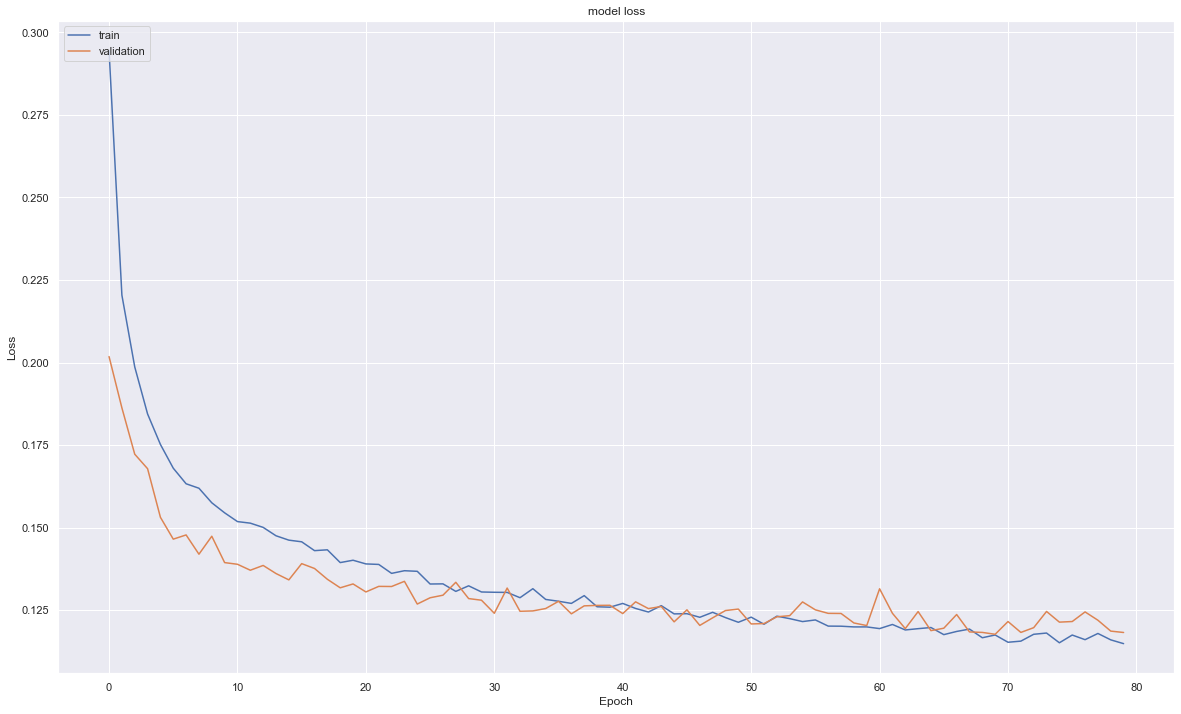

In [267]:
# Plotting Train Loss vs Validation Loss
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])

plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Best Threshold=0.565504, G-Mean=0.950


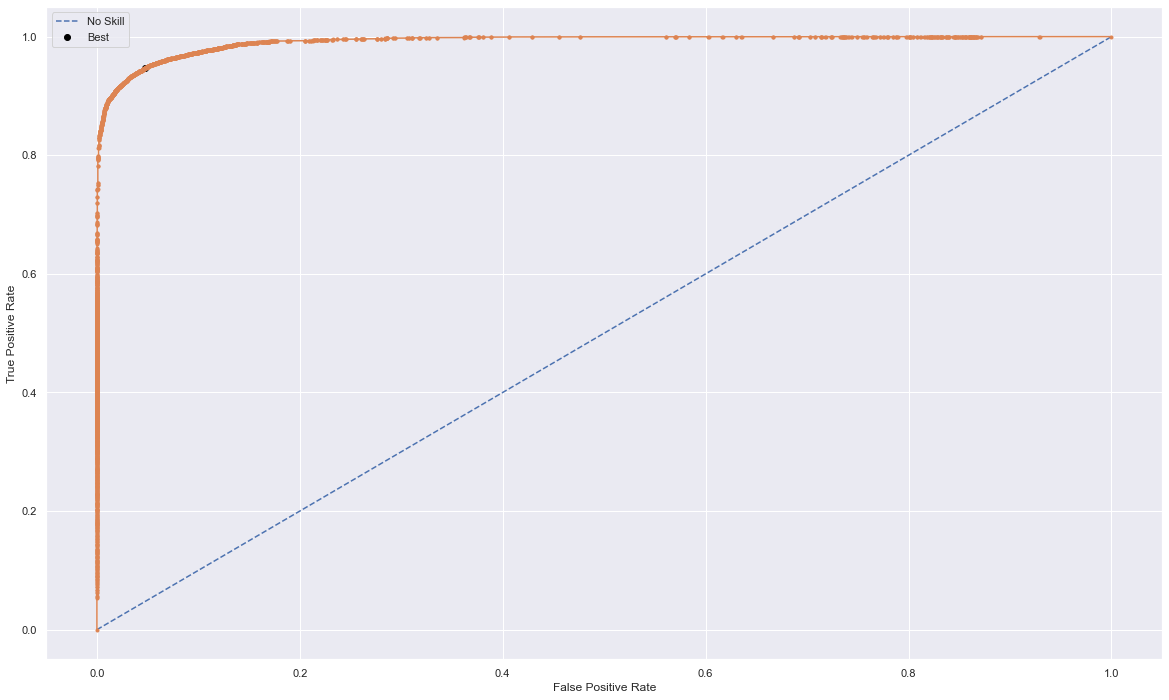

In [268]:
# Predict probabilities
yhat4 = estimator_v4.predict(X_test)

# Keep probabilities for the positive outcome only
yhat4 = yhat4[:, 0]

# Calculate roc curves
fpr, tpr, thresholds4 = roc_curve(y_test, yhat4)

# Calculate the g-mean for each threshold
gmeans4 = np.sqrt(tpr * (1-fpr))

# Locate the index of the largest g-mean
ix = np.argmax(gmeans4)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds4[ix], gmeans4[ix]))

# Plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# Axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# Show the plot
pyplot.show()

In [269]:
y_pred_e4 = estimator_v4.predict(X_test)
y_pred_e4 = (y_pred_e4 > thresholds4[ix])
y_pred_e4_f=y_pred_e4.astype('int64')
y_pred_e4

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      7799
         1.0       0.96      0.95      0.95      9557

    accuracy                           0.95     17356
   macro avg       0.95      0.95      0.95     17356
weighted avg       0.95      0.95      0.95     17356



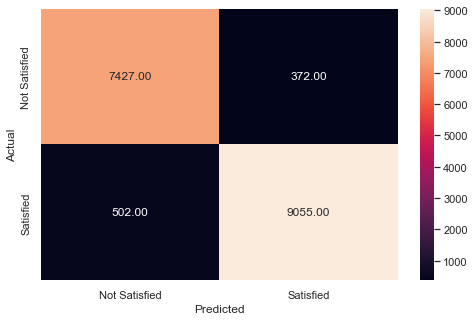

In [270]:
metrics_score(y_test, y_pred_e4)

This final model is as accurate, however precision and recall seems more homogenous. This will have to be validate over real data in production.

# Conclusion

In conclusion, other models can be tested like Adaboost, light Gbm or further tunning neural networks. Other preprocessing methods could be used for example relating to NaN. Feature engeneering could implement feature augmentation through featuretools library for example. However the XGBoost on this dataset reaches above target with very low computational cost. 